Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. 
Выполнить прогноз для примеров из тестового датасета.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn import model_selection
from sklearn.metrics import precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

In [98]:
train_data = pd.read_csv('./Data/train.csv')
test_data = pd.read_csv('./Data/test.csv')

## Анализ данных

In [99]:
train_data.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговое обременение
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Score - кредитный рейтинг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Есть пропуски в данных

### Выявление выбросов

In [101]:
train_data.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

Посмотрим на минимальные, максимальные и средние значения по каждому признаку для выявления выбросов и некорректных значений:

#### Признаки Maximum Open Credit, Current Credit Balance, Monthly Debt

In [102]:
#смущает, что минимальное значение у признака Maximum Open Credit=0 при том, что у клиента открыт кредит и есть ежемесячный платеж
train_data.loc[train_data['Maximum Open Credit']==0]

Home Ownership  Annual Income Years in current job  Tax Liens  \
8     Home Mortgage            NaN              5 years        0.0   
91             Rent       601369.0            10+ years        0.0   
196            Rent       815157.0              7 years        0.0   
294   Home Mortgage      2033931.0              7 years        0.0   
309            Rent      1245792.0              3 years        0.0   
319        Own Home            NaN             < 1 year        0.0   
544   Home Mortgage            NaN              2 years        0.0   
585   Home Mortgage      4772800.0              8 years        0.0   
602   Home Mortgage      5631030.0               1 year        0.0   
611            Rent       756846.0               1 year        0.0   
780   Home Mortgage       867749.0            10+ years        0.0   
1163  Home Mortgage      4523064.0              3 years        0.0   
1338           Rent            NaN              2 years        0.0   
1404           Rent       349391.0             < 1 year        0.0   
1427  Home Mortgage            NaN            10+ years        0.0   
1464  Home Mortgage      2432000.0            10+ years        0.0   
1483  Home Mortgage            NaN              7 years        0.0   
1637           Rent      1345295.0            10+ years        0.0   
1643           Rent            NaN              9 years        0.0   
1672           Rent      1788584.0            10+ years        0.0   
1684  Home Mortgage       845348.0              4 years        0.0   
1802           Rent      1043651.0             < 1 year        0.0   
1816  Home Mortgage            NaN            10+ years        0.0   
1894           Rent       958094.0              8 years        0.0   
1984  Home Mortgage      8758449.0            10+ years        0.0   
2081  Home Mortgage      1960648.0            10+ years        0.0   
2276           Rent      2086067.0            10+ years        0.0   
2297  Home Mortgage      1263785.0              8 years        0.0   
2446  Home Mortgage            NaN              5 years        0.0   
2640           Rent       973560.0                  NaN        0.0   
...             ...            ...                  ...        ...   
3496           Rent       233567.0               1 year        0.0   
3539           Rent            NaN             < 1 year        0.0   
3624  Home Mortgage       746852.0              5 years        0.0   
3647           Rent            NaN              3 years        0.0   
3780  Home Mortgage       801724.0            10+ years        0.0   
3900           Rent            NaN            10+ years        0.0   
3938       Own Home      1328575.0              9 years        0.0   
4119  Home Mortgage       959557.0              2 years        0.0   
4165           Rent      1254513.0            10+ years        0.0   
4256           Rent            NaN              4 years        0.0   
4274           Rent      2257903.0              6 years        0.0   
4295  Home Mortgage            NaN              9 years        0.0   
4335  Home Mortgage      1396082.0              2 years        0.0   
4382       Own Home      4190792.0              2 years        0.0   
4398           Rent       983820.0               1 year        0.0   
4405  Home Mortgage            NaN              6 years        0.0   
4958           Rent       890701.0              2 years        0.0   
4962       Own Home      1893464.0            10+ years        0.0   
5114           Rent      1281455.0              8 years        0.0   
5287  Home Mortgage       872347.0              6 years        0.0   
5395  Home Mortgage            NaN              4 years        0.0   
5688           Rent      1338474.0             < 1 year        0.0   
5720  Home Mortgage            NaN            10+ years        0.0   
6189           Rent       713127.0              3 years        0.0   
6591  Home Mortgage            NaN            10+ years        0.0   
6593  Home Mort

Таких клиентов всего 65.

In [103]:
#посмотрим сколько таких клиентов в тестовой выборке
test_data.loc[test_data['Maximum Open Credit']==0].shape

(14, 16)

In [104]:
#тоже самое с текущим кредитным балансом
train_data.loc[train_data['Current Credit Balance']==0].shape

(53, 17)

In [105]:
#посмотрим на пересечение двух признаков
train_data.loc[(train_data['Current Credit Balance']==0) & (train_data['Maximum Open Credit']==0)].shape

(53, 17)

Возможно, это клиенты, у которых есть последний платеж по кредиту и кредит будет закрыт.

In [106]:
#нулевой ежемесячный долг
train_data.loc[train_data['Monthly Debt']==0].shape

(6, 17)

In [107]:
#клиенты с нулевым ежемесячным долгом,нулевым текущем кредитным балансом и нулевым максимально открытым кредитом
train_data.loc[(train_data['Monthly Debt']==0) & (train_data['Current Credit Balance']==0) & (train_data['Maximum Open Credit']==0)]

Home Ownership  Annual Income Years in current job  Tax Liens  \
780   Home Mortgage       867749.0            10+ years        0.0   
1643           Rent            NaN              9 years        0.0   
3219  Home Mortgage            NaN            10+ years        0.0   
3496           Rent       233567.0               1 year        0.0   
4165           Rent      1254513.0            10+ years        0.0   
7124           Rent            NaN               1 year        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
780                       2.0                     16.5                  0.0   
1643                      3.0                     10.0                  0.0   
3219                      3.0                     18.5                  0.0   
3496                      7.0                     11.7                  0.0   
4165                      6.0                     23.4                  0.0   
7124                      4.0                     11.0                  0.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
780                         0.0                          66.0           0.0   
1643                        0.0                           NaN           0.0   
3219                        0.0                           NaN           0.0   
3496                        0.0                           0.0           NaN   
4165                        0.0                          60.0           0.0   
7124                        0.0                          50.0           0.0   

                   Purpose        Term  Current Loan Amount  \
780      home improvements  Short Term              75350.0   
1643                 other  Short Term             332156.0   
3219    debt consolidation  Short Term              79200.0   
3496  educational expenses  Short Term             210166.0   
4165           take a trip  Short Term           99999999.0   
7124    debt consolidation  Short Term             134024.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
780                      0.0           0.0         704.0               0  
1643                     0.0           0.0           NaN               1  
3219                     0.0           0.0           NaN               0  
3496                     0.0           0.0         746.0               0  
4165                     0.0           0.0         748.0               0  
7124                     0.0           0.0           NaN               0

Удаление данных выбросов уменьшает качество модели, поэтому оставим их.

#### Признак Credit Score

У признака 'Credit Score' резко различаются минимальное и максимальное значения в выборке.

In [108]:
train_data.loc[(train_data['Credit Score'] >1000)]

Home Ownership  Annual Income Years in current job  Tax Liens  \
69    Home Mortgage      1408527.0              2 years        0.0   
87    Home Mortgage      1533566.0              7 years        0.0   
94             Rent      1049294.0              3 years        0.0   
96             Rent       757568.0              5 years        0.0   
116   Home Mortgage      1039984.0                  NaN        0.0   
152   Home Mortgage      1026817.0            10+ years        0.0   
153            Rent       749816.0              9 years        0.0   
198            Rent      2298240.0            10+ years        0.0   
217   Home Mortgage      1733674.0            10+ years        0.0   
263   Home Mortgage      1910678.0            10+ years        0.0   
267   Home Mortgage      2104003.0              4 years        0.0   
297            Rent       556662.0             < 1 year        0.0   
325            Rent       468312.0              6 years        0.0   
340            Rent       673987.0              2 years        0.0   
355            Rent       960184.0            10+ years        0.0   
380   Home Mortgage       956840.0            10+ years        0.0   
435            Rent      1251435.0              4 years        0.0   
452        Own Home      1071125.0              4 years        0.0   
515   Home Mortgage      1618629.0              6 years        0.0   
534        Own Home       412072.0            10+ years        0.0   
541            Rent       935465.0            10+ years        0.0   
587   Home Mortgage       813086.0              2 years        0.0   
590        Own Home       931665.0              3 years        0.0   
605   Home Mortgage       871644.0                  NaN        0.0   
609            Rent      1002402.0              6 years        0.0   
629   Home Mortgage      1389337.0              4 years        0.0   
670   Home Mortgage      1132704.0               1 year        0.0   
718            Rent      1345162.0              6 years        0.0   
753   Home Mortgage      1225006.0              3 years        0.0   
763   Home Mortgage      1516200.0              2 years        0.0   
...             ...            ...                  ...        ...   
7087  Home Mortgage       776891.0              3 years        0.0   
7125  Home Mortgage      1334256.0              5 years        0.0   
7153           Rent      1305262.0              2 years        0.0   
7163           Rent      1428287.0              2 years        0.0   
7184           Rent       240122.0             < 1 year        0.0   
7192  Home Mortgage      2517671.0              4 years        0.0   
7200           Rent       842004.0              2 years        0.0   
7211  Home Mortgage      1135991.0              8 years        0.0   
7212       Own Home      1415177.0            10+ years        0.0   
7223       Own Home       994327.0            10+ years        0.0   
7241           Rent       671916.0             < 1 year        0.0   
7243           Rent      1154934.0              2 years        0.0   
7264  Home Mortgage      1035177.0            10+ years        0.0   
7265  Home Mortgage      1151590.0              4 years        0.0   
7282       Own Home       569373.0                  NaN        0.0   
7288  Home Mortgage      3835416.0              9 years        0.0   
7298           Rent      1353218.0            10+ years        0.0   
7301  Home Mortgage       624093.0            10+ years        0.0   
7333           Rent       383306.0             < 1 year        0.0   
7350  Home Mortgage       705812.0              3 years        0.0   
7353           Rent       973750.0               1 year        0.0   
7354  Home Mortgage      1334066.0              7 years        0.0   
7355  Home Mortgage       989406.0              3 years        0.0   
7364           Rent       680162.0              5 years        0.0   
7379       Own Home       290415.0             < 1 year        0.0   
7422           

In [109]:
train_data.loc[(train_data['Credit Score'] >800) & (train_data['Credit Score']<1000)].shape

(0, 17)

In [110]:
train_data.loc[(train_data['Credit Score'] >1000) & (train_data['Credit Default']==0)].shape

(0, 17)

Минимальное значение признака 'Credit Score' = 585, а максимальное = 7510. При этом нет значений более 800 и менее 1000, что наталкивает на мысль, о том, что данные некорректно заполнены.
Однако, у всех клиентов со значением этого признака более 1000 целевая переменная равна 1 и это дает хороший прирост качества модели.

#### Количественные признаки

In [111]:
#категориальные признаки 
cat_columns = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#количественные признаки
quant_columns = ['Annual Income', 'Tax Liens', 'Bankruptcies', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                 'Number of Credit Problems', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance',
                 'Monthly Debt', 'Credit Score']

Посмотрим на боксплоты количественных признаков:

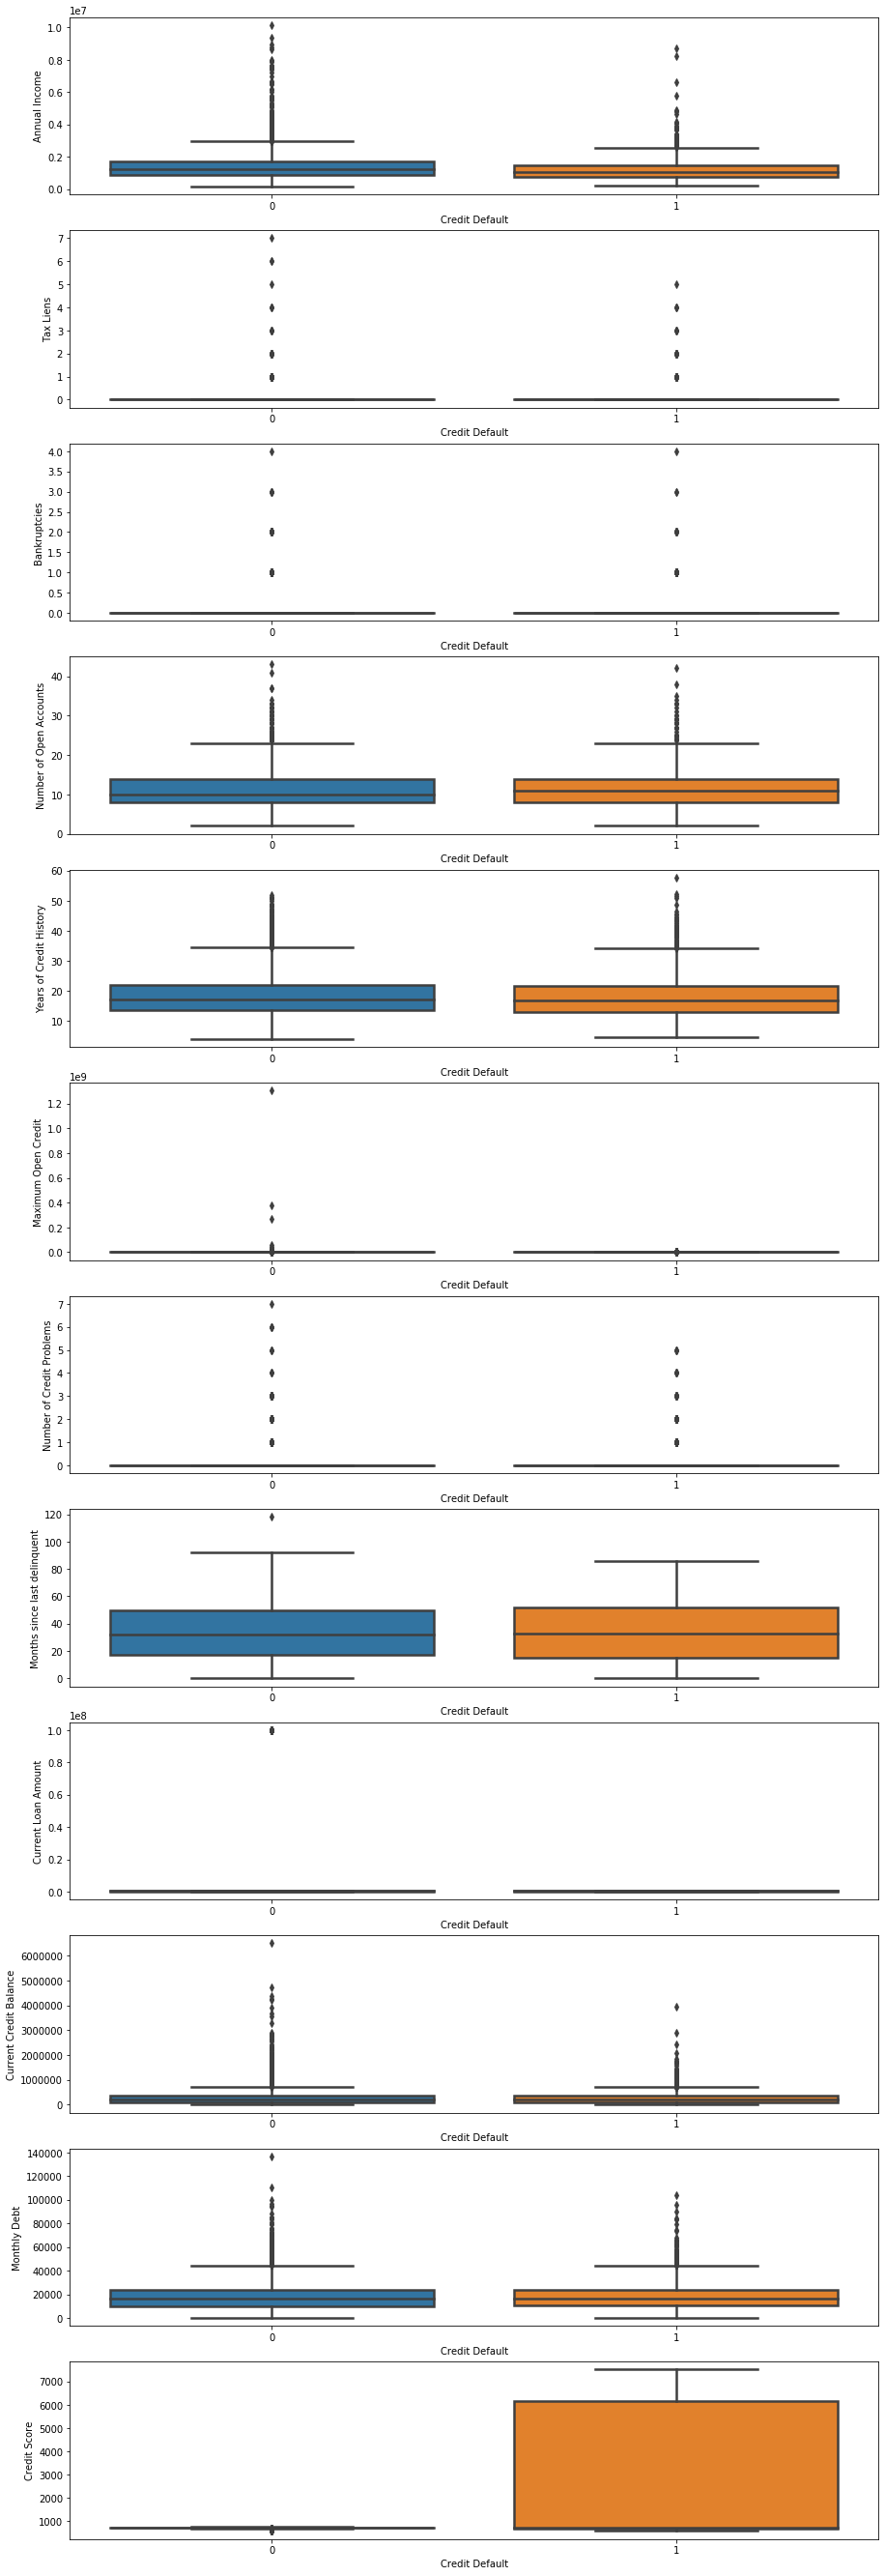

In [112]:
fig, ax = plt.subplots(ncols=1, nrows=len(quant_columns), figsize=(15, 4*len(quant_columns)))
for i, name in enumerate(quant_columns):
    sns.boxplot(x='Credit Default', y=name, data=train_data, linewidth=2.5, ax=ax[i])

In [113]:
# Сделаем выборку объектов-выбросов

# основная часть клиентов в выборке (98%) не имеет налогового обременения
train_data.loc[train_data['Tax Liens']==0].shape

(7366, 17)

In [114]:
# основная часть клиентов в выборке (89%) не было банкротами
train_data.loc[train_data['Bankruptcies']==0].shape

(6660, 17)

In [115]:
# есть один клиент в выборке, у которого максимально открытый кредит составляет 1,3 млрд
train_data.loc[train_data['Maximum Open Credit']>1_200_000_000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
617  Home Mortgage            NaN              3 years        0.0   

     Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
617                     13.0                     27.5         1.304726e+09   

     Number of Credit Problems  Months since last delinquent  Bankruptcies  \
617                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
617  debt consolidation  Short Term             529892.0   

     Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
617               1126814.0        5492.0           NaN               0

Возможно, максимально открытая сумма кредита меньше на два порядка и сопоставима с текущим кредитным балансом этого клиента.
При таком варианте сумма=1,3млрд могла возникнуть из-за ошибки ввода данных.


In [116]:
# основная часть клиентов в выборке (86%) не было банкротами
train_data.loc[train_data['Number of Credit Problems']==0].shape

(6469, 17)

In [117]:
# есть один клиент в выборке, у которого 118 месяцев (почти 10 лет) прошло с последней просрочки платежа
# возможно, 10 лет назад была просрочка и больше их не было
train_data.loc[train_data['Months since last delinquent']>100]

Home Ownership  Annual Income Years in current job  Tax Liens  \
4191  Home Mortgage      3009201.0              6 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
4191                     10.0                     20.8             773322.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
4191                        0.0                         118.0           0.0   

                 Purpose        Term  Current Loan Amount  \
4191  debt consolidation  Short Term             449592.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
4191                299877.0       15297.0         738.0               0

In [118]:
# клиенты, у которох довольно интересная текущая сумма кредита
#выглядит как ошибка в заполнении данных
train_data.loc[train_data['Current Loan Amount']>99_999_000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0                  NaN        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
6     Home Mortgage      1511108.0            10+ years        0.0   
22             Rent       463790.0                  NaN        0.0   
27             Rent      1004055.0              8 years        0.0   
30             Rent       612750.0              7 years        0.0   
31         Own Home      1289796.0            10+ years        0.0   
46    Home Mortgage      1721457.0            10+ years        0.0   
61    Home Mortgage       866476.0               1 year        0.0   
67             Rent      1269333.0             < 1 year        0.0   
76             Rent       808298.0              5 years        0.0   
97             Rent       840541.0              6 years        0.0   
100        Own Home       337079.0               1 year        0.0   
104            Rent      1194834.0              3 years        0.0   
108            Rent      1390306.0                  NaN        0.0   
110            Rent      1131545.0              3 years        0.0   
121            Rent       405346.0              2 years        0.0   
125   Home Mortgage      1004207.0              6 years        0.0   
146   Home Mortgage       700625.0                  NaN        0.0   
147            Rent      1576791.0               1 year        0.0   
148   Home Mortgage      2676758.0            10+ years        0.0   
151   Home Mortgage      1440257.0              4 years        0.0   
160            Rent       756276.0              2 years        0.0   
163            Rent       735528.0              4 years        0.0   
166   Home Mortgage      4580976.0              4 years        0.0   
168   Home Mortgage      2379522.0              2 years        0.0   
170   Home Mortgage       664810.0            10+ years        0.0   
192            Rent       929575.0               1 year        0.0   
207            Rent      1130196.0              6 years        0.0   
209   Home Mortgage      2685536.0            10+ years        0.0   
...             ...            ...                  ...        ...   
7203       Own Home       908466.0              3 years        0.0   
7205  Home Mortgage      2303028.0              7 years        0.0   
7208           Rent      1765879.0              2 years        0.0   
7218  Home Mortgage      1136770.0              8 years        0.0   
7220           Rent      1029667.0              2 years        0.0   
7237           Rent       752248.0            10+ years        0.0   
7260           Rent       306793.0             < 1 year        0.0   
7276  Home Mortgage      1188146.0              6 years        0.0   
7277  Home Mortgage      1791472.0            10+ years        0.0   
7285  Home Mortgage      1028242.0              7 years        0.0   
7292  Home Mortgage      1414892.0              8 years        0.0   
7306           Rent      1424012.0             < 1 year        0.0   
7314           Rent       325299.0                  NaN        0.0   
7319  Home Mortgage       901132.0              4 years        0.0   
7320       Own Home      1277275.0            10+ years        0.0   
7327           Rent       575814.0            10+ years        0.0   
7330           Rent       932995.0              7 years        0.0   
7334       Own Home       816506.0            10+ years        0.0   
7335  Home Mortgage       951805.0              2 years        0.0   
7339       Own Home       244416.0               1 year        0.0   
7340  Home Mortgage      1511336.0            10+ years        0.0   
7344           Rent      3105056.0            10+ years        0.0   
7376  Home Mortgage       504146.0              4 years        0.0   
7431           Rent      1065463.0               1 year        0.0   
7439  Home Mortgage       671270.0                  NaN        0.0   
7441           

In [119]:
# клиенты с текущим кредитным балансом более 4 млн. В принципе, нормальные клиенты,ничего странного в них не вижу. 
# просто хорошо зарабатывают
train_data.loc[train_data['Current Credit Balance']>4_000_000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
1580  Home Mortgage      3783660.0               1 year        0.0   
4602  Home Mortgage      3990038.0            10+ years        0.0   
4745       Own Home      6029954.0              4 years        0.0   
4769  Home Mortgage      3739960.0              9 years        0.0   
7278       Own Home      2418415.0                  NaN        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
1580                      9.0                     17.0            7204516.0   
4602                     10.0                     23.0            9541136.0   
4745                     30.0                     17.5           11603856.0   
4769                      7.0                     22.8           26343328.0   
7278                     13.0                     14.0            7453138.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
1580                        0.0                           NaN           0.0   
4602                        0.0                           5.0           0.0   
4745                        0.0                           NaN           0.0   
4769                        0.0                           NaN           0.0   
7278                        0.0                          45.0           0.0   

                 Purpose        Term  Current Loan Amount  \
1580  debt consolidation  Short Term           99999999.0   
4602   home improvements   Long Term             788788.0   
4745  debt consolidation  Short Term             753588.0   
4769   home improvements  Short Term             757834.0   
7278  debt consolidation   Long Term             440088.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
1580               4249673.0       42251.0         739.0               0  
4602               4367245.0       29792.0         687.0               0  
4745               4720132.0      136679.0         745.0               0  
4769               6506797.0       38023.0         703.0               0  
7278               4209659.0       29626.0         714.0               0

In [120]:
# клиент с довольно высоким ежемесячным долгом. Видимо, клиент за счет высокого ежемесячного платежа быстро выплачивает кредит, 
# тем более, что его годовой доход позволяет это сделать.
train_data.loc[train_data['Monthly Debt']>120_000]

Home Ownership  Annual Income Years in current job  Tax Liens  \
4745       Own Home      6029954.0              4 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
4745                     30.0                     17.5           11603856.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
4745                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
4745  debt consolidation  Short Term             753588.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
4745               4720132.0      136679.0         745.0               0

Удаление выбросов по данным признакам ухудшает качество модели, поэтому оставим их в выборке.

### Работа с пропусками

In [121]:
# заполним нулями недостающие значения у признака 'Bankruptcies' (т.к. это самое частое значение признака)
# также, если нет информации, то мы не можем присвоить клиенту банкротство
train_data['Bankruptcies'] = train_data['Bankruptcies'].fillna(0)

In [122]:
#заполним -1 недостающие значения у признака "Months since last delinquent - количество месяцев с последней просрочки платежа"
# посколько значение признака=nan указывает на отсутствие просрочек
train_data['Months since last delinquent'] = train_data['Months since last delinquent'].fillna(-1)

In [123]:
#посмотрим на распределение признака 'Years in current job'
train_data['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Большая часть клиентов в выборке имеет стаж на текущем месте работы более 10 лет. Однако заполнять недостающие значения этого признака стажем более 10 лет мне кажется некорректным, т.к. это довольно высокий показатель.
Поэтому заполню недостающие значения значением "< 1 year".

In [124]:
train_data['Years in current job'] = train_data['Years in current job'].fillna('< 1 year')

В выборке одинаковое количество отсутствующих значений у признаков 'Credit Score' и 'Annual Income'. Проверим, совпадают ли они:

In [125]:
train_data.loc[train_data['Credit Score'].isnull()].shape

(1557, 17)

In [126]:
train_data.loc[train_data['Credit Score'].isnull() & train_data['Annual Income'].isnull()].shape

(1557, 17)

Видим, что отсутствующие значения у этих столбцов совпадают.
Можно попробовать удалить клиентов с недостающими данными у этих признаков и далее анализировать только 5943 клиентов. Однако, тогда мы удалим существенную часть выборки, около 20%.
Поэтому заполним недостающие значения, без удаления части выборки: для Annual Income - средним значением, а 
для  Credit Score - медианой (т.к. качество модели при таком выборе увеличивается)

In [127]:
train_data['Credit Score'] = train_data['Credit Score'].fillna(train_data['Credit Score'].median())
train_data['Annual Income'] = train_data['Annual Income'].fillna(train_data['Annual Income'].mean())

In [128]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7

Теперь пропусков нет

### Визуальный анализ данных

In [129]:
# посмотрим на распределение целевого признака
train_data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

2113 клиентов (28%) не выполняли кредитных обязательств (просрочка была).

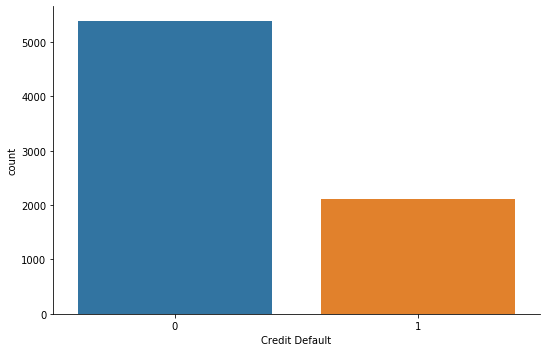

In [130]:
sns.catplot(x='Credit Default',data=train_data,kind='count',height=5,aspect=1.5)

Проанализируем категориальные признаки:

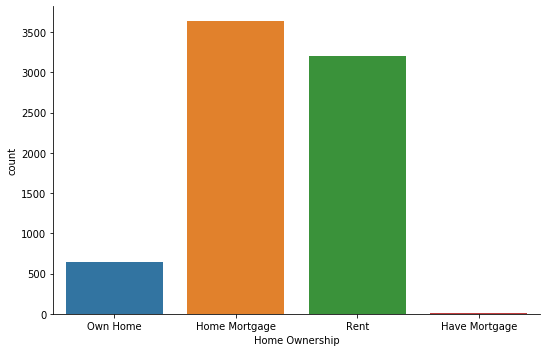

In [131]:
#домовладение
sns.catplot(x='Home Ownership',data=train_data,kind='count',height=5,aspect=1.5)

У наибольшей части клиентов в выборке домовладение в ипотеке либо в аренде.


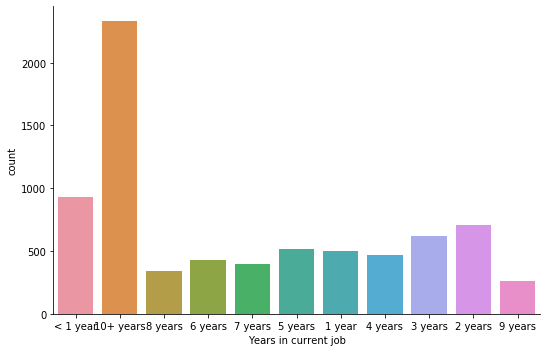

In [132]:
#стаж на текущем месте работы
sns.catplot(x='Years in current job',data=train_data,kind='count',height=5,aspect=1.5)

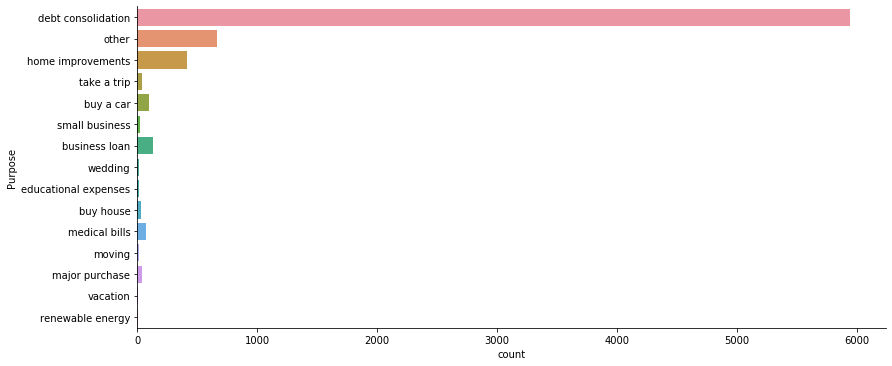

In [133]:
sns.catplot(y='Purpose',data=train_data,kind='count',height=5,aspect=2.5)

Основной целью кредита у клиентов в выборке является консолидация долгов.

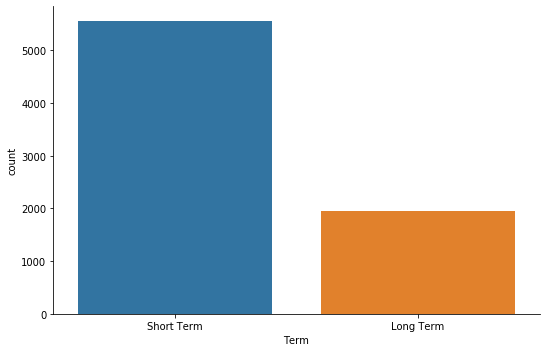

In [134]:
sns.catplot(x='Term',data=train_data,kind='count',height=5,aspect=1.5)

Большая часть клиентов берет краткосрочные кредиты

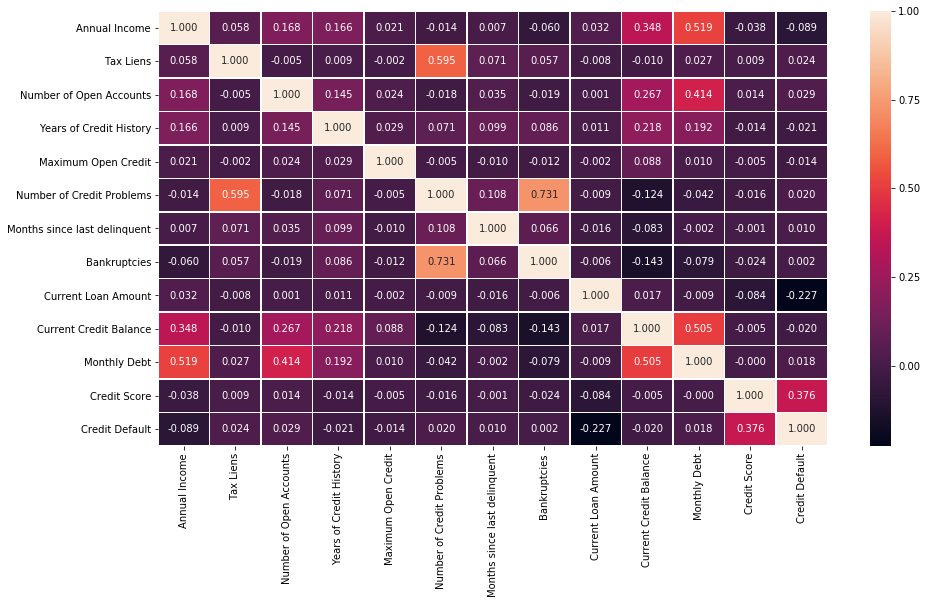

In [135]:
#построим матрицу корреляций
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, fmt=".3f", linewidths=0.5)

Признаки банкротство и число кредитных проблем достаточно сильно скоррелированны. 
Нет сильной корреляции таргета с каким-либо из количественных признаков. Целевая переменная имеет наибольшую корреляцию с кредитным рейтингом.

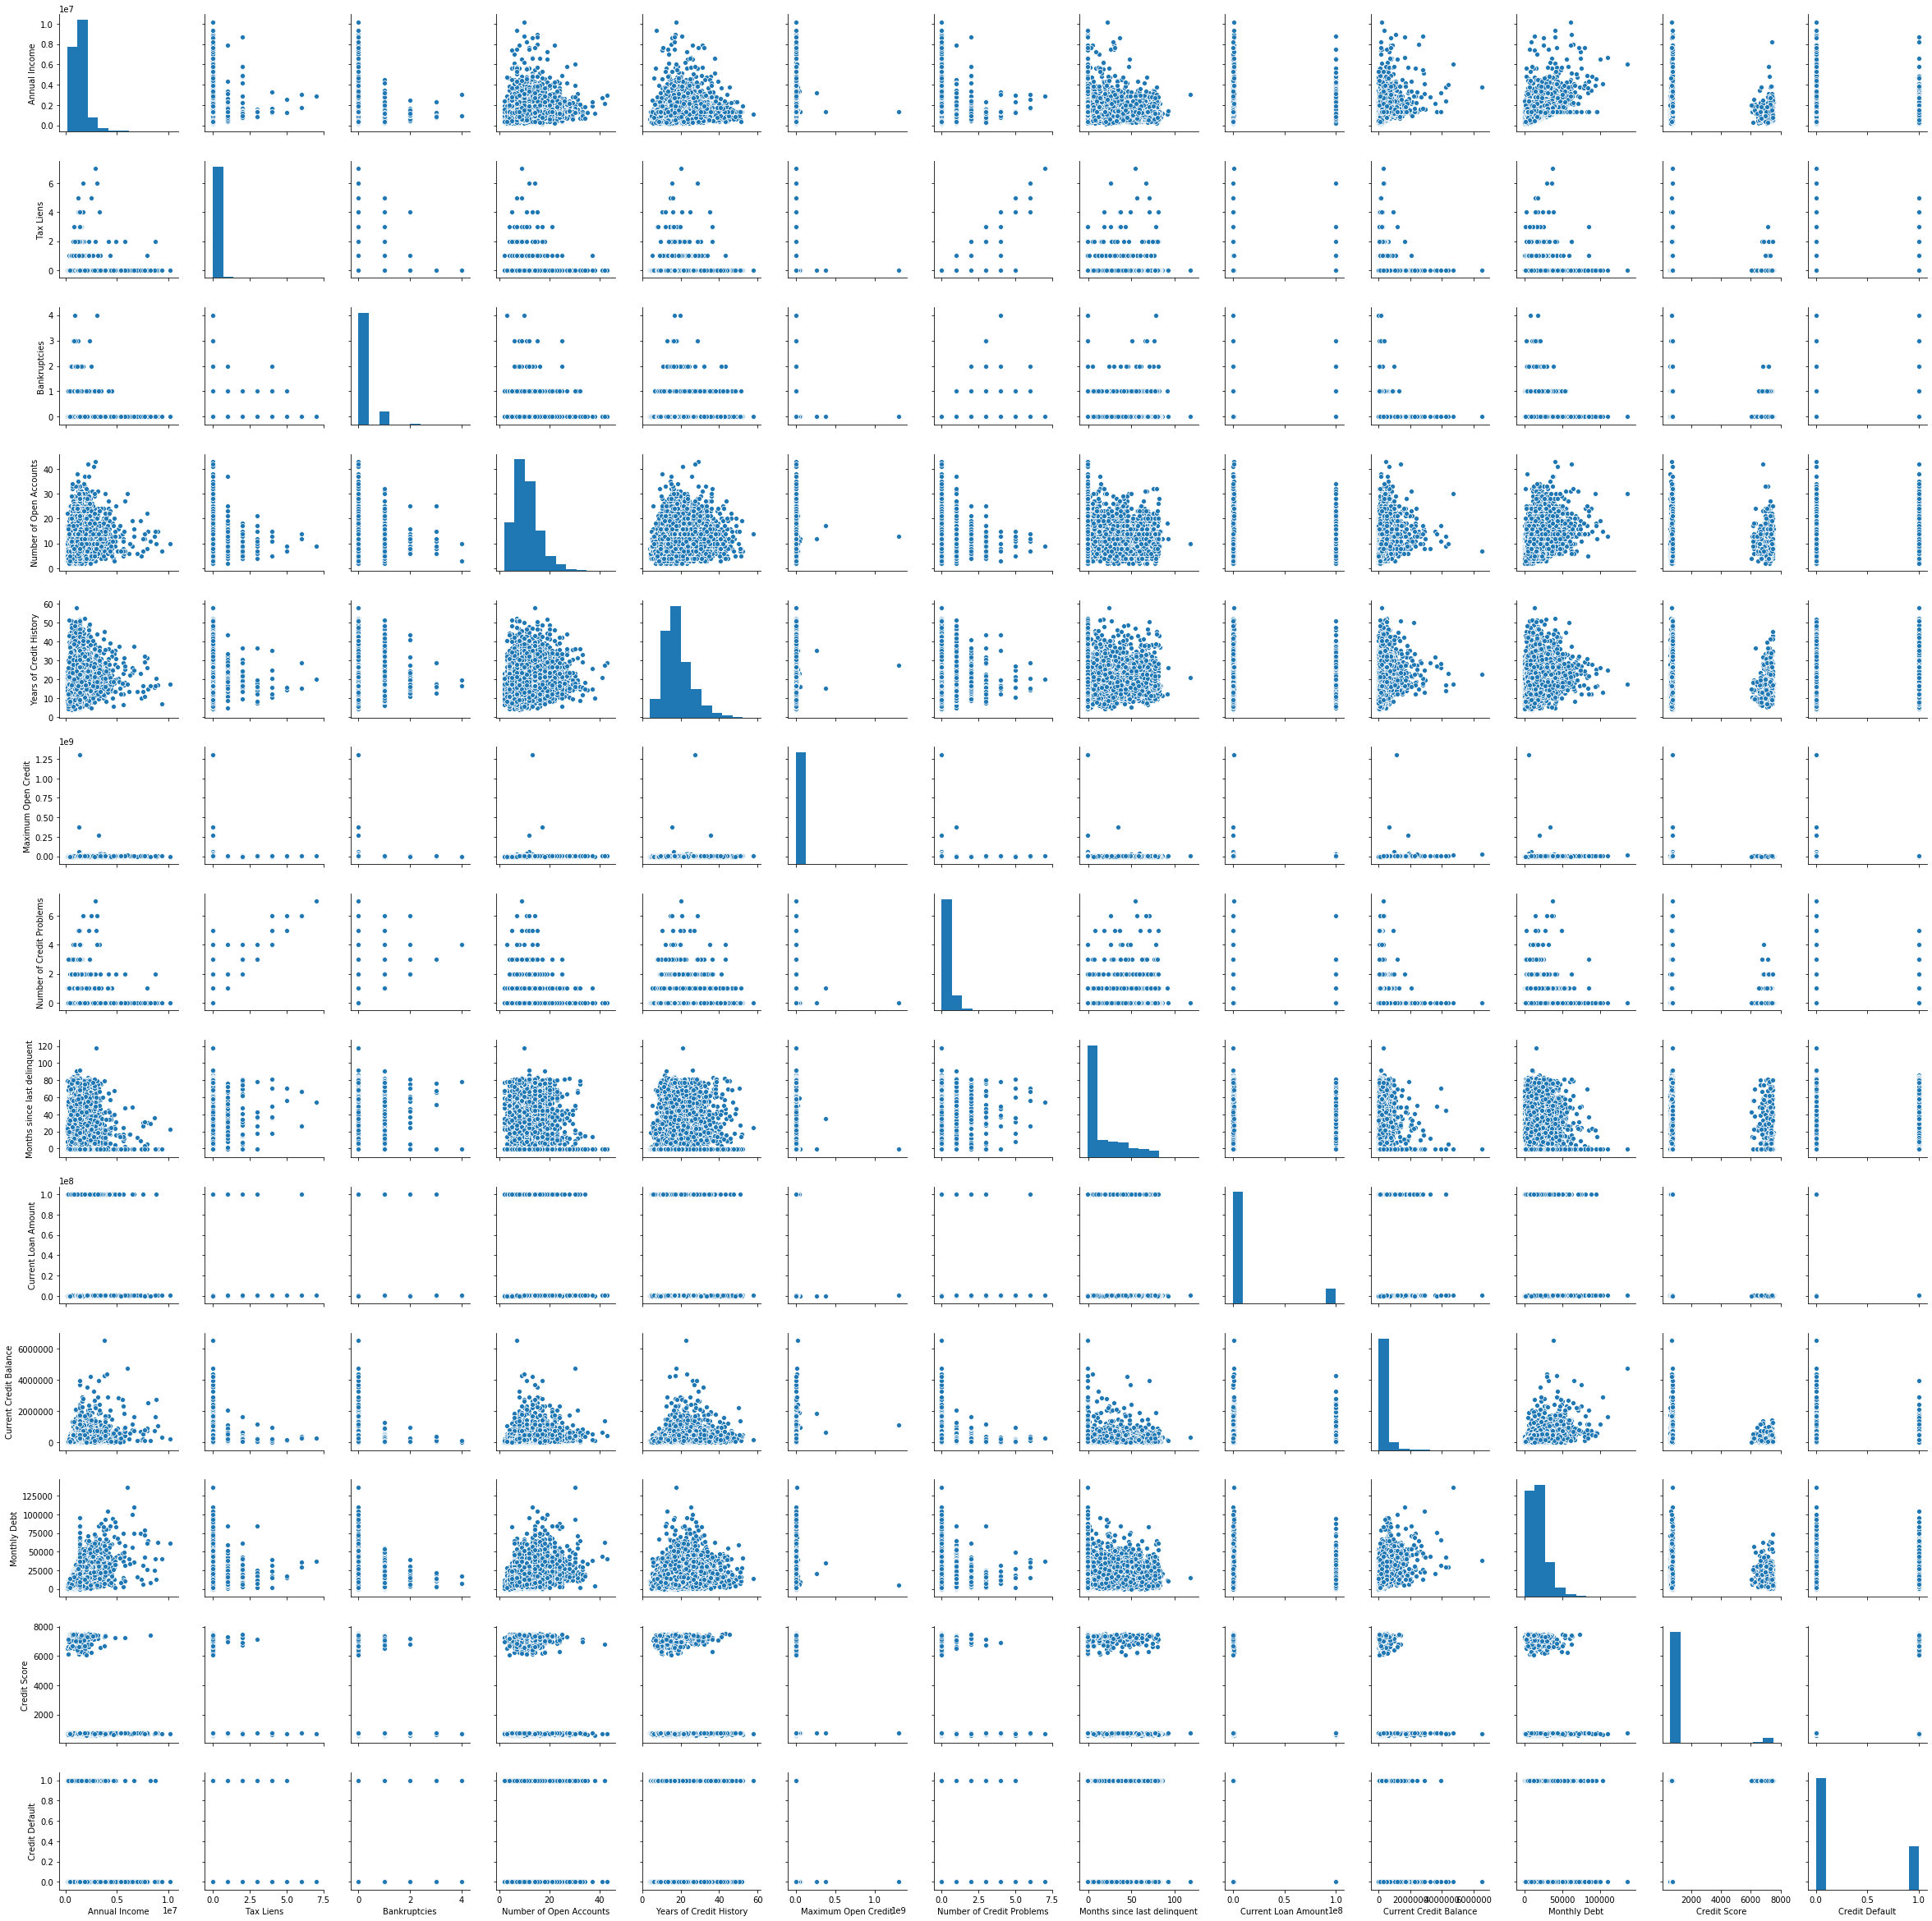

In [136]:
#посмотрим как связаны между собой количественные признаки
sns.pairplot(train_data.loc[:, quant_columns+['Credit Default']])

Явных зависимостей в парах признаков не наблюдается. 
Можно выделить пару 'Tax Liens' и 'Number of Credit Problems', в которых видно, что чем выше налоговое обременение, тем выше число кредитных проблем. 


## Генерация новых признаков

Вместо признаков банкротства, налогооблажения, кредитных проблем создадим новые признаки их наличия или отсутствия.
Также создадим признак наличия просрочки вместо Months since last delinquent, т.к. у этого признака почти половина значений=nan.

In [137]:
train_data['Has_delinquent'] = [0 if x==-1 else 1 for x in train_data['Months since last delinquent']]
train_data['Has_bankruptcies'] = [0 if x==0 else 1 for x in train_data['Bankruptcies']]
train_data['Has_Tax_Liens'] = [0 if x==0 else 1 for x in train_data['Tax Liens']]
train_data['Has_Number_of_Credit_Problems'] = [0 if x==0 else 1 for x in train_data['Number of Credit Problems']]

Создание таких признаков, как:
* отношение текущего кредитного баланса к ежемесячному долгу (оставшееся примерное кол-во месяцев до погашения кредита)
* деление кредитного рейтинга на категории (чтобы выявить категорию дефолтных клиентов)
* отношение текущей суммы кредита к текущему кредитному балансу (величина показывает сколько месяцев клиент платит)  
не дали улучшения модели.

## Модель

In [138]:
# отдельно выделим целевую переменную
train_target = train_data['Credit Default']

In [139]:
train_df = train_data.drop(['Credit Default'], axis=1)

Попробуем catboost, т.к. он быстро работает и для него не нужно делать one-hot-encoder  категориальных признаков, потому что он умеет работать с ними.

In [44]:
#категориальные признаки 
cat_columns = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Has_delinquent', 'Has_bankruptcies',
               'Has_Tax_Liens', 'Has_Number_of_Credit_Problems']

#количественные признаки
quant_columns = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 
                 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [45]:
sss = model_selection.StratifiedShuffleSplit(n_splits=5, train_size=0.6, test_size=0.4, random_state=42)
PR, RC, F1 = list(), list(), list()
for tr_ind, te_ind in sss.split(train_df.loc[:, cat_columns+quant_columns], train_target):
    X_train, X_test = train_df.loc[tr_ind, cat_columns+quant_columns], train_df.loc[te_ind, cat_columns+quant_columns]
    y_train, y_test = train_target[tr_ind], train_target[te_ind]
    model = CatBoostClassifier(loss_function='Logloss', eval_metric='F1', random_state=42)
    model.fit(X_train, y_train, cat_features=cat_columns, eval_set=(X_test, y_test), use_best_model=True, plot=False)
    predictions = model.predict(X_test)
    PR.append(precision_score(predictions, y_test))
    RC.append(recall_score(predictions, y_test))
    F1.append(f1_score(predictions, y_test))
    
print(sum(PR)/len(PR))
print(sum(RC)/len(RC))
print(sum(F1)/len(F1))

Learning rate set to 0.091377
0:	learn: 0.2594372	test: 0.3100000	best: 0.3100000 (0)	total: 161ms	remaining: 2m 40s
1:	learn: 0.3002681	test: 0.3457031	best: 0.3457031 (1)	total: 179ms	remaining: 1m 29s
2:	learn: 0.2934051	test: 0.3382498	best: 0.3457031 (1)	total: 204ms	remaining: 1m 7s
3:	learn: 0.2934051	test: 0.3382498	best: 0.3457031 (1)	total: 231ms	remaining: 57.5s
4:	learn: 0.2922559	test: 0.3382498	best: 0.3457031 (1)	total: 250ms	remaining: 49.7s
5:	learn: 0.2922559	test: 0.3382498	best: 0.3457031 (1)	total: 268ms	remaining: 44.4s
6:	learn: 0.2945528	test: 0.3398821	best: 0.3457031 (1)	total: 284ms	remaining: 40.4s
7:	learn: 0.2945528	test: 0.3398821	best: 0.3457031 (1)	total: 302ms	remaining: 37.5s
8:	learn: 0.2945528	test: 0.3382498	best: 0.3457031 (1)	total: 320ms	remaining: 35.2s
9:	learn: 0.2945528	test: 0.3382498	best: 0.3457031 (1)	total: 338ms	remaining: 33.5s
10:	learn: 0.2945528	test: 0.3382498	best: 0.3457031 (1)	total: 356ms	remaining: 32s
11:	learn: 0.2934051	te

100:	learn: 0.5000000	test: 0.4293286	best: 0.4330080 (96)	total: 1.89s	remaining: 16.8s
101:	learn: 0.5005834	test: 0.4297082	best: 0.4330080 (96)	total: 1.91s	remaining: 16.9s
102:	learn: 0.5043681	test: 0.4327177	best: 0.4330080 (96)	total: 1.93s	remaining: 16.8s
103:	learn: 0.5069767	test: 0.4348592	best: 0.4348592 (103)	total: 1.95s	remaining: 16.8s
104:	learn: 0.5066822	test: 0.4352423	best: 0.4352423 (104)	total: 1.96s	remaining: 16.7s
105:	learn: 0.5115741	test: 0.4376098	best: 0.4376098 (105)	total: 1.98s	remaining: 16.7s
106:	learn: 0.5138568	test: 0.4379947	best: 0.4379947 (106)	total: 2s	remaining: 16.7s
107:	learn: 0.5158684	test: 0.4379947	best: 0.4379947 (106)	total: 2.01s	remaining: 16.6s
108:	learn: 0.5164265	test: 0.4362357	best: 0.4379947 (106)	total: 2.03s	remaining: 16.6s
109:	learn: 0.5212400	test: 0.4366197	best: 0.4379947 (106)	total: 2.05s	remaining: 16.6s
110:	learn: 0.5209409	test: 0.4344767	best: 0.4379947 (106)	total: 2.07s	remaining: 16.6s
111:	learn: 0.52

195:	learn: 0.6663223	test: 0.4619205	best: 0.4700997 (184)	total: 3.55s	remaining: 14.6s
196:	learn: 0.6656331	test: 0.4589892	best: 0.4700997 (184)	total: 3.57s	remaining: 14.5s
197:	learn: 0.6680434	test: 0.4598842	best: 0.4700997 (184)	total: 3.59s	remaining: 14.5s
198:	learn: 0.6701031	test: 0.4628099	best: 0.4700997 (184)	total: 3.6s	remaining: 14.5s
199:	learn: 0.6707946	test: 0.4636964	best: 0.4700997 (184)	total: 3.62s	remaining: 14.5s
200:	learn: 0.6714801	test: 0.4644628	best: 0.4700997 (184)	total: 3.63s	remaining: 14.4s
201:	learn: 0.6721649	test: 0.4653465	best: 0.4700997 (184)	total: 3.65s	remaining: 14.4s
202:	learn: 0.6721649	test: 0.4645799	best: 0.4700997 (184)	total: 3.67s	remaining: 14.4s
203:	learn: 0.6728490	test: 0.4630542	best: 0.4700997 (184)	total: 3.69s	remaining: 14.4s
204:	learn: 0.6745501	test: 0.4610336	best: 0.4700997 (184)	total: 3.7s	remaining: 14.4s
205:	learn: 0.6765914	test: 0.4606557	best: 0.4700997 (184)	total: 3.71s	remaining: 14.3s
206:	learn: 

291:	learn: 0.7614458	test: 0.4717131	best: 0.4773270 (284)	total: 5.22s	remaining: 12.7s
292:	learn: 0.7610790	test: 0.4733916	best: 0.4773270 (284)	total: 5.24s	remaining: 12.6s
293:	learn: 0.7610790	test: 0.4721781	best: 0.4773270 (284)	total: 5.25s	remaining: 12.6s
294:	learn: 0.7622714	test: 0.4725537	best: 0.4773270 (284)	total: 5.27s	remaining: 12.6s
295:	learn: 0.7604819	test: 0.4721781	best: 0.4773270 (284)	total: 5.29s	remaining: 12.6s
296:	learn: 0.7622714	test: 0.4753577	best: 0.4773270 (284)	total: 5.31s	remaining: 12.6s
297:	learn: 0.7634615	test: 0.4746032	best: 0.4773270 (284)	total: 5.33s	remaining: 12.5s
298:	learn: 0.7634615	test: 0.4746032	best: 0.4773270 (284)	total: 5.34s	remaining: 12.5s
299:	learn: 0.7654676	test: 0.4769475	best: 0.4773270 (284)	total: 5.36s	remaining: 12.5s
300:	learn: 0.7654676	test: 0.4765687	best: 0.4773270 (284)	total: 5.38s	remaining: 12.5s
301:	learn: 0.7660594	test: 0.4758128	best: 0.4773270 (284)	total: 5.4s	remaining: 12.5s
302:	learn:

384:	learn: 0.8294467	test: 0.4738893	best: 0.4793130 (376)	total: 6.86s	remaining: 11s
385:	learn: 0.8294467	test: 0.4738893	best: 0.4793130 (376)	total: 6.88s	remaining: 10.9s
386:	learn: 0.8294467	test: 0.4735202	best: 0.4793130 (376)	total: 6.9s	remaining: 10.9s
387:	learn: 0.8289113	test: 0.4723305	best: 0.4793130 (376)	total: 6.92s	remaining: 10.9s
388:	learn: 0.8289113	test: 0.4726989	best: 0.4793130 (376)	total: 6.93s	remaining: 10.9s
389:	learn: 0.8289113	test: 0.4734375	best: 0.4793130 (376)	total: 6.95s	remaining: 10.9s
390:	learn: 0.8294467	test: 0.4710485	best: 0.4793130 (376)	total: 6.97s	remaining: 10.9s
391:	learn: 0.8299817	test: 0.4714174	best: 0.4793130 (376)	total: 6.99s	remaining: 10.8s
392:	learn: 0.8294467	test: 0.4721569	best: 0.4793130 (376)	total: 7s	remaining: 10.8s
393:	learn: 0.8314299	test: 0.4734375	best: 0.4793130 (376)	total: 7.02s	remaining: 10.8s
394:	learn: 0.8330292	test: 0.4734375	best: 0.4793130 (376)	total: 7.04s	remaining: 10.8s
395:	learn: 0.83

476:	learn: 0.8763748	test: 0.4766355	best: 0.4813084 (442)	total: 8.51s	remaining: 9.33s
477:	learn: 0.8778559	test: 0.4778210	best: 0.4813084 (442)	total: 8.53s	remaining: 9.31s
478:	learn: 0.8778559	test: 0.4774495	best: 0.4813084 (442)	total: 8.54s	remaining: 9.29s
479:	learn: 0.8803157	test: 0.4774495	best: 0.4813084 (442)	total: 8.56s	remaining: 9.28s
480:	learn: 0.8808063	test: 0.4767081	best: 0.4813084 (442)	total: 8.58s	remaining: 9.26s
481:	learn: 0.8798246	test: 0.4774495	best: 0.4813084 (442)	total: 8.6s	remaining: 9.24s
482:	learn: 0.8803157	test: 0.4770785	best: 0.4813084 (442)	total: 8.62s	remaining: 9.22s
483:	learn: 0.8798246	test: 0.4770785	best: 0.4813084 (442)	total: 8.63s	remaining: 9.2s
484:	learn: 0.8808063	test: 0.4767081	best: 0.4813084 (442)	total: 8.65s	remaining: 9.19s
485:	learn: 0.8812965	test: 0.4767081	best: 0.4813084 (442)	total: 8.67s	remaining: 9.16s
486:	learn: 0.8817863	test: 0.4778898	best: 0.4813084 (442)	total: 8.69s	remaining: 9.15s
487:	learn: 

568:	learn: 0.9093242	test: 0.4763359	best: 0.4813084 (442)	total: 10.2s	remaining: 7.71s
569:	learn: 0.9097905	test: 0.4740061	best: 0.4813084 (442)	total: 10.2s	remaining: 7.69s
570:	learn: 0.9097905	test: 0.4721161	best: 0.4813084 (442)	total: 10.2s	remaining: 7.68s
571:	learn: 0.9097905	test: 0.4721161	best: 0.4813084 (442)	total: 10.2s	remaining: 7.66s
572:	learn: 0.9097905	test: 0.4709480	best: 0.4813084 (442)	total: 10.3s	remaining: 7.64s
573:	learn: 0.9107219	test: 0.4748092	best: 0.4813084 (442)	total: 10.3s	remaining: 7.63s
574:	learn: 0.9107219	test: 0.4732824	best: 0.4813084 (442)	total: 10.3s	remaining: 7.61s
575:	learn: 0.9125800	test: 0.4748092	best: 0.4813084 (442)	total: 10.3s	remaining: 7.59s
576:	learn: 0.9139693	test: 0.4755352	best: 0.4813084 (442)	total: 10.3s	remaining: 7.58s
577:	learn: 0.9144317	test: 0.4774292	best: 0.4813084 (442)	total: 10.4s	remaining: 7.56s
578:	learn: 0.9144317	test: 0.4774292	best: 0.4813084 (442)	total: 10.4s	remaining: 7.54s
579:	learn

666:	learn: 0.9373957	test: 0.4757576	best: 0.4821835 (629)	total: 12s	remaining: 6.01s
667:	learn: 0.9378390	test: 0.4784254	best: 0.4821835 (629)	total: 12.1s	remaining: 5.99s
668:	learn: 0.9382819	test: 0.4773414	best: 0.4821835 (629)	total: 12.1s	remaining: 5.98s
669:	learn: 0.9387245	test: 0.4761905	best: 0.4821835 (629)	total: 12.1s	remaining: 5.96s
670:	learn: 0.9382819	test: 0.4750378	best: 0.4821835 (629)	total: 12.1s	remaining: 5.95s
671:	learn: 0.9387245	test: 0.4761905	best: 0.4821835 (629)	total: 12.1s	remaining: 5.93s
672:	learn: 0.9382819	test: 0.4758308	best: 0.4821835 (629)	total: 12.2s	remaining: 5.91s
673:	learn: 0.9404911	test: 0.4777694	best: 0.4821835 (629)	total: 12.2s	remaining: 5.9s
674:	learn: 0.9400500	test: 0.4792766	best: 0.4821835 (629)	total: 12.2s	remaining: 5.88s
675:	learn: 0.9396085	test: 0.4792766	best: 0.4821835 (629)	total: 12.2s	remaining: 5.87s
676:	learn: 0.9404911	test: 0.4781297	best: 0.4821835 (629)	total: 12.3s	remaining: 5.86s
677:	learn: 0

760:	learn: 0.9585896	test: 0.4713855	best: 0.4839432 (716)	total: 14.1s	remaining: 4.43s
761:	learn: 0.9581624	test: 0.4720965	best: 0.4839432 (716)	total: 14.1s	remaining: 4.41s
762:	learn: 0.9594429	test: 0.4720965	best: 0.4839432 (716)	total: 14.1s	remaining: 4.39s
763:	learn: 0.9594429	test: 0.4705882	best: 0.4839432 (716)	total: 14.2s	remaining: 4.37s
764:	learn: 0.9594429	test: 0.4717408	best: 0.4839432 (716)	total: 14.2s	remaining: 4.36s
765:	learn: 0.9594429	test: 0.4720965	best: 0.4839432 (716)	total: 14.2s	remaining: 4.34s
766:	learn: 0.9594429	test: 0.4717408	best: 0.4839432 (716)	total: 14.2s	remaining: 4.32s
767:	learn: 0.9602947	test: 0.4721805	best: 0.4839432 (716)	total: 14.2s	remaining: 4.3s
768:	learn: 0.9594429	test: 0.4736842	best: 0.4839432 (716)	total: 14.3s	remaining: 4.29s
769:	learn: 0.9594429	test: 0.4725357	best: 0.4839432 (716)	total: 14.3s	remaining: 4.27s
770:	learn: 0.9594429	test: 0.4728916	best: 0.4839432 (716)	total: 14.3s	remaining: 4.25s
771:	learn:

855:	learn: 0.9745660	test: 0.4827586	best: 0.4839432 (716)	total: 16.4s	remaining: 2.75s
856:	learn: 0.9745660	test: 0.4850299	best: 0.4850299 (856)	total: 16.4s	remaining: 2.74s
857:	learn: 0.9745660	test: 0.4850299	best: 0.4850299 (856)	total: 16.4s	remaining: 2.72s
858:	learn: 0.9745660	test: 0.4843049	best: 0.4850299 (856)	total: 16.4s	remaining: 2.7s
859:	learn: 0.9749798	test: 0.4824496	best: 0.4850299 (856)	total: 16.5s	remaining: 2.68s
860:	learn: 0.9749798	test: 0.4817301	best: 0.4850299 (856)	total: 16.5s	remaining: 2.66s
861:	learn: 0.9745865	test: 0.4820896	best: 0.4850299 (856)	total: 16.5s	remaining: 2.64s
862:	learn: 0.9754131	test: 0.4809559	best: 0.4850299 (856)	total: 16.5s	remaining: 2.63s
863:	learn: 0.9754131	test: 0.4816754	best: 0.4850299 (856)	total: 16.6s	remaining: 2.61s
864:	learn: 0.9754131	test: 0.4816754	best: 0.4850299 (856)	total: 16.6s	remaining: 2.59s
865:	learn: 0.9750000	test: 0.4816754	best: 0.4850299 (856)	total: 16.6s	remaining: 2.57s
866:	learn:

950:	learn: 0.9827655	test: 0.4817844	best: 0.4865672 (872)	total: 18.5s	remaining: 952ms
951:	learn: 0.9823577	test: 0.4840386	best: 0.4865672 (872)	total: 18.5s	remaining: 932ms
952:	learn: 0.9823577	test: 0.4843982	best: 0.4865672 (872)	total: 18.5s	remaining: 913ms
953:	learn: 0.9827655	test: 0.4825538	best: 0.4865672 (872)	total: 18.5s	remaining: 894ms
954:	learn: 0.9827655	test: 0.4814264	best: 0.4865672 (872)	total: 18.6s	remaining: 874ms
955:	learn: 0.9831731	test: 0.4821429	best: 0.4865672 (872)	total: 18.6s	remaining: 855ms
956:	learn: 0.9831731	test: 0.4828614	best: 0.4865672 (872)	total: 18.6s	remaining: 835ms
957:	learn: 0.9831731	test: 0.4825019	best: 0.4865672 (872)	total: 18.6s	remaining: 816ms
958:	learn: 0.9831731	test: 0.4813711	best: 0.4865672 (872)	total: 18.6s	remaining: 797ms
959:	learn: 0.9831731	test: 0.4832215	best: 0.4865672 (872)	total: 18.7s	remaining: 777ms
960:	learn: 0.9831731	test: 0.4832215	best: 0.4865672 (872)	total: 18.7s	remaining: 758ms
961:	learn

48:	learn: 0.4280443	test: 0.3371648	best: 0.3371648 (48)	total: 986ms	remaining: 19.1s
49:	learn: 0.4290104	test: 0.3374880	best: 0.3374880 (49)	total: 1s	remaining: 19s
50:	learn: 0.4294479	test: 0.3406699	best: 0.3406699 (50)	total: 1.02s	remaining: 19s
51:	learn: 0.4318043	test: 0.3419293	best: 0.3419293 (51)	total: 1.04s	remaining: 19s
52:	learn: 0.4339853	test: 0.3416031	best: 0.3419293 (51)	total: 1.06s	remaining: 18.9s
53:	learn: 0.4318043	test: 0.3428571	best: 0.3428571 (53)	total: 1.08s	remaining: 18.9s
54:	learn: 0.4349420	test: 0.3444339	best: 0.3444339 (54)	total: 1.1s	remaining: 18.9s
55:	learn: 0.4375381	test: 0.3456790	best: 0.3456790 (55)	total: 1.12s	remaining: 18.8s
56:	learn: 0.4413374	test: 0.3469194	best: 0.3469194 (56)	total: 1.14s	remaining: 18.8s
57:	learn: 0.4432301	test: 0.3446970	best: 0.3469194 (56)	total: 1.15s	remaining: 18.7s
58:	learn: 0.4460606	test: 0.3443709	best: 0.3469194 (56)	total: 1.17s	remaining: 18.7s
59:	learn: 0.4457904	test: 0.3459357	best:

151:	learn: 0.6092573	test: 0.3921569	best: 0.3950178 (150)	total: 3.05s	remaining: 17s
152:	learn: 0.6071044	test: 0.3942908	best: 0.3950178 (150)	total: 3.07s	remaining: 17s
153:	learn: 0.6078537	test: 0.3957219	best: 0.3957219 (153)	total: 3.09s	remaining: 17s
154:	learn: 0.6108427	test: 0.3967972	best: 0.3967972 (154)	total: 3.12s	remaining: 17s
155:	learn: 0.6167825	test: 0.3946667	best: 0.3967972 (154)	total: 3.14s	remaining: 17s
156:	learn: 0.6171123	test: 0.3911111	best: 0.3967972 (154)	total: 3.16s	remaining: 16.9s
157:	learn: 0.6185897	test: 0.3925400	best: 0.3967972 (154)	total: 3.18s	remaining: 16.9s
158:	learn: 0.6273259	test: 0.3946667	best: 0.3967972 (154)	total: 3.2s	remaining: 16.9s
159:	learn: 0.6251994	test: 0.3943162	best: 0.3967972 (154)	total: 3.22s	remaining: 16.9s
160:	learn: 0.6237360	test: 0.3964602	best: 0.3967972 (154)	total: 3.24s	remaining: 16.9s
161:	learn: 0.6255319	test: 0.3925400	best: 0.3967972 (154)	total: 3.26s	remaining: 16.9s
162:	learn: 0.6266596

249:	learn: 0.7302372	test: 0.4119658	best: 0.4119658 (249)	total: 5.11s	remaining: 15.3s
250:	learn: 0.7327416	test: 0.4119658	best: 0.4119658 (249)	total: 5.14s	remaining: 15.3s
251:	learn: 0.7321164	test: 0.4119658	best: 0.4119658 (249)	total: 5.16s	remaining: 15.3s
252:	learn: 0.7312253	test: 0.4106074	best: 0.4119658 (249)	total: 5.18s	remaining: 15.3s
253:	learn: 0.7322134	test: 0.4133219	best: 0.4133219 (253)	total: 5.2s	remaining: 15.3s
254:	learn: 0.7363233	test: 0.4099061	best: 0.4133219 (253)	total: 5.22s	remaining: 15.3s
255:	learn: 0.7363233	test: 0.4081981	best: 0.4133219 (253)	total: 5.24s	remaining: 15.2s
256:	learn: 0.7381890	test: 0.4081981	best: 0.4133219 (253)	total: 5.26s	remaining: 15.2s
257:	learn: 0.7400491	test: 0.4078498	best: 0.4133219 (253)	total: 5.28s	remaining: 15.2s
258:	learn: 0.7400491	test: 0.4064902	best: 0.4133219 (253)	total: 5.31s	remaining: 15.2s
259:	learn: 0.7428852	test: 0.4044369	best: 0.4133219 (253)	total: 5.33s	remaining: 15.2s
260:	learn:

344:	learn: 0.8065421	test: 0.4168067	best: 0.4181360 (340)	total: 7.13s	remaining: 13.5s
345:	learn: 0.8070995	test: 0.4117647	best: 0.4181360 (340)	total: 7.16s	remaining: 13.5s
346:	learn: 0.8087687	test: 0.4144295	best: 0.4181360 (340)	total: 7.18s	remaining: 13.5s
347:	learn: 0.8076564	test: 0.4127517	best: 0.4181360 (340)	total: 7.21s	remaining: 13.5s
348:	learn: 0.8082128	test: 0.4127517	best: 0.4181360 (340)	total: 7.23s	remaining: 13.5s
349:	learn: 0.8093240	test: 0.4134454	best: 0.4181360 (340)	total: 7.25s	remaining: 13.5s
350:	learn: 0.8093240	test: 0.4134454	best: 0.4181360 (340)	total: 7.27s	remaining: 13.4s
351:	learn: 0.8093240	test: 0.4141414	best: 0.4181360 (340)	total: 7.29s	remaining: 13.4s
352:	learn: 0.8087687	test: 0.4161752	best: 0.4181360 (340)	total: 7.31s	remaining: 13.4s
353:	learn: 0.8098788	test: 0.4165261	best: 0.4181360 (340)	total: 7.33s	remaining: 13.4s
354:	learn: 0.8098788	test: 0.4154752	best: 0.4181360 (340)	total: 7.36s	remaining: 13.4s
355:	learn

442:	learn: 0.8505643	test: 0.4232365	best: 0.4265560 (436)	total: 9.17s	remaining: 11.5s
443:	learn: 0.8516013	test: 0.4222776	best: 0.4265560 (436)	total: 9.2s	remaining: 11.5s
444:	learn: 0.8526363	test: 0.4222776	best: 0.4265560 (436)	total: 9.22s	remaining: 11.5s
445:	learn: 0.8536695	test: 0.4196503	best: 0.4265560 (436)	total: 9.24s	remaining: 11.5s
446:	learn: 0.8510830	test: 0.4189526	best: 0.4265560 (436)	total: 9.26s	remaining: 11.5s
447:	learn: 0.8505643	test: 0.4189526	best: 0.4265560 (436)	total: 9.28s	remaining: 11.4s
448:	learn: 0.8495255	test: 0.4205298	best: 0.4265560 (436)	total: 9.3s	remaining: 11.4s
449:	learn: 0.8500452	test: 0.4188742	best: 0.4265560 (436)	total: 9.32s	remaining: 11.4s
450:	learn: 0.8505643	test: 0.4231405	best: 0.4265560 (436)	total: 9.34s	remaining: 11.4s
451:	learn: 0.8530207	test: 0.4240924	best: 0.4265560 (436)	total: 9.36s	remaining: 11.3s
452:	learn: 0.8540541	test: 0.4240924	best: 0.4265560 (436)	total: 9.38s	remaining: 11.3s
453:	learn: 

540:	learn: 0.9067469	test: 0.4285714	best: 0.4315961 (496)	total: 11.3s	remaining: 9.55s
541:	learn: 0.9062769	test: 0.4272949	best: 0.4315961 (496)	total: 11.3s	remaining: 9.53s
542:	learn: 0.9072165	test: 0.4285714	best: 0.4315961 (496)	total: 11.3s	remaining: 9.51s
543:	learn: 0.9076857	test: 0.4266018	best: 0.4315961 (496)	total: 11.3s	remaining: 9.49s
544:	learn: 0.9072165	test: 0.4282238	best: 0.4315961 (496)	total: 11.3s	remaining: 9.46s
545:	learn: 0.9062769	test: 0.4289196	best: 0.4315961 (496)	total: 11.4s	remaining: 9.44s
546:	learn: 0.9081545	test: 0.4276423	best: 0.4315961 (496)	total: 11.4s	remaining: 9.42s
547:	learn: 0.9076064	test: 0.4283388	best: 0.4315961 (496)	total: 11.4s	remaining: 9.4s
548:	learn: 0.9085444	test: 0.4266018	best: 0.4315961 (496)	total: 11.4s	remaining: 9.38s
549:	learn: 0.9090129	test: 0.4275304	best: 0.4315961 (496)	total: 11.4s	remaining: 9.37s
550:	learn: 0.9095585	test: 0.4297254	best: 0.4315961 (496)	total: 11.5s	remaining: 9.35s
551:	learn:

635:	learn: 0.9300758	test: 0.4275304	best: 0.4380032 (614)	total: 13.3s	remaining: 7.61s
636:	learn: 0.9305263	test: 0.4288026	best: 0.4380032 (614)	total: 13.3s	remaining: 7.59s
637:	learn: 0.9291737	test: 0.4304207	best: 0.4380032 (614)	total: 13.3s	remaining: 7.57s
638:	learn: 0.9296249	test: 0.4309927	best: 0.4380032 (614)	total: 13.4s	remaining: 7.55s
639:	learn: 0.9296249	test: 0.4297254	best: 0.4380032 (614)	total: 13.4s	remaining: 7.53s
640:	learn: 0.9296249	test: 0.4281099	best: 0.4380032 (614)	total: 13.4s	remaining: 7.51s
641:	learn: 0.9300758	test: 0.4255663	best: 0.4380032 (614)	total: 13.4s	remaining: 7.49s
642:	learn: 0.9309764	test: 0.4252223	best: 0.4380032 (614)	total: 13.4s	remaining: 7.46s
643:	learn: 0.9314262	test: 0.4249797	best: 0.4380032 (614)	total: 13.5s	remaining: 7.44s
644:	learn: 0.9314262	test: 0.4237013	best: 0.4380032 (614)	total: 13.5s	remaining: 7.42s
645:	learn: 0.9309764	test: 0.4249797	best: 0.4380032 (614)	total: 13.5s	remaining: 7.4s
646:	learn:

731:	learn: 0.9525382	test: 0.4301766	best: 0.4380032 (614)	total: 15.4s	remaining: 5.62s
732:	learn: 0.9538335	test: 0.4292605	best: 0.4380032 (614)	total: 15.4s	remaining: 5.6s
733:	learn: 0.9538335	test: 0.4289157	best: 0.4380032 (614)	total: 15.4s	remaining: 5.58s
734:	learn: 0.9546952	test: 0.4273092	best: 0.4380032 (614)	total: 15.4s	remaining: 5.56s
735:	learn: 0.9542645	test: 0.4317817	best: 0.4380032 (614)	total: 15.4s	remaining: 5.54s
736:	learn: 0.9546952	test: 0.4289157	best: 0.4380032 (614)	total: 15.5s	remaining: 5.52s
737:	learn: 0.9542645	test: 0.4296058	best: 0.4380032 (614)	total: 15.5s	remaining: 5.5s
738:	learn: 0.9555556	test: 0.4305221	best: 0.4380032 (614)	total: 15.5s	remaining: 5.48s
739:	learn: 0.9555556	test: 0.4308682	best: 0.4380032 (614)	total: 15.5s	remaining: 5.46s
740:	learn: 0.9555556	test: 0.4301766	best: 0.4380032 (614)	total: 15.6s	remaining: 5.44s
741:	learn: 0.9555556	test: 0.4301766	best: 0.4380032 (614)	total: 15.6s	remaining: 5.42s
742:	learn: 

828:	learn: 0.9733010	test: 0.4320890	best: 0.4380032 (614)	total: 17.5s	remaining: 3.61s
829:	learn: 0.9728855	test: 0.4305004	best: 0.4380032 (614)	total: 17.5s	remaining: 3.59s
830:	learn: 0.9728855	test: 0.4329897	best: 0.4380032 (614)	total: 17.5s	remaining: 3.56s
831:	learn: 0.9733010	test: 0.4280032	best: 0.4380032 (614)	total: 17.6s	remaining: 3.54s
832:	learn: 0.9733010	test: 0.4295943	best: 0.4380032 (614)	total: 17.6s	remaining: 3.52s
833:	learn: 0.9733010	test: 0.4299363	best: 0.4380032 (614)	total: 17.6s	remaining: 3.5s
834:	learn: 0.9737161	test: 0.4276630	best: 0.4380032 (614)	total: 17.6s	remaining: 3.48s
835:	learn: 0.9741310	test: 0.4276630	best: 0.4380032 (614)	total: 17.6s	remaining: 3.46s
836:	learn: 0.9737161	test: 0.4276630	best: 0.4380032 (614)	total: 17.7s	remaining: 3.44s
837:	learn: 0.9733010	test: 0.4273233	best: 0.4380032 (614)	total: 17.7s	remaining: 3.42s
838:	learn: 0.9733010	test: 0.4276630	best: 0.4380032 (614)	total: 17.7s	remaining: 3.4s
839:	learn: 

926:	learn: 0.9815409	test: 0.4311854	best: 0.4380032 (614)	total: 19.6s	remaining: 1.54s
927:	learn: 0.9819495	test: 0.4283439	best: 0.4380032 (614)	total: 19.6s	remaining: 1.52s
928:	learn: 0.9819495	test: 0.4295943	best: 0.4380032 (614)	total: 19.6s	remaining: 1.5s
929:	learn: 0.9819495	test: 0.4299363	best: 0.4380032 (614)	total: 19.7s	remaining: 1.48s
930:	learn: 0.9819495	test: 0.4306220	best: 0.4380032 (614)	total: 19.7s	remaining: 1.46s
931:	learn: 0.9819495	test: 0.4315287	best: 0.4380032 (614)	total: 19.7s	remaining: 1.44s
932:	learn: 0.9823577	test: 0.4315287	best: 0.4380032 (614)	total: 19.7s	remaining: 1.42s
933:	learn: 0.9823577	test: 0.4306220	best: 0.4380032 (614)	total: 19.7s	remaining: 1.4s
934:	learn: 0.9827655	test: 0.4309657	best: 0.4380032 (614)	total: 19.8s	remaining: 1.37s
935:	learn: 0.9827655	test: 0.4309657	best: 0.4380032 (614)	total: 19.8s	remaining: 1.35s
936:	learn: 0.9827655	test: 0.4306220	best: 0.4380032 (614)	total: 19.8s	remaining: 1.33s
937:	learn: 

17:	learn: 0.3293808	test: 0.2946519	best: 0.2963710 (6)	total: 372ms	remaining: 20.3s
18:	learn: 0.3293808	test: 0.2929293	best: 0.2963710 (6)	total: 391ms	remaining: 20.2s
19:	learn: 0.3293808	test: 0.2929293	best: 0.2963710 (6)	total: 414ms	remaining: 20.3s
20:	learn: 0.3304806	test: 0.2946519	best: 0.2963710 (6)	total: 434ms	remaining: 20.2s
21:	learn: 0.3304806	test: 0.2929293	best: 0.2963710 (6)	total: 451ms	remaining: 20s
22:	learn: 0.3304806	test: 0.2929293	best: 0.2963710 (6)	total: 461ms	remaining: 19.6s
23:	learn: 0.3315789	test: 0.2946519	best: 0.2963710 (6)	total: 475ms	remaining: 19.3s
24:	learn: 0.3337714	test: 0.2946519	best: 0.2963710 (6)	total: 494ms	remaining: 19.3s
25:	learn: 0.3337714	test: 0.2963710	best: 0.2963710 (6)	total: 513ms	remaining: 19.2s
26:	learn: 0.3381389	test: 0.2963710	best: 0.2963710 (6)	total: 533ms	remaining: 19.2s
27:	learn: 0.3403141	test: 0.2980866	best: 0.2980866 (27)	total: 560ms	remaining: 19.5s
28:	learn: 0.3403141	test: 0.2980866	best: 0

113:	learn: 0.5212888	test: 0.3778802	best: 0.3778802 (112)	total: 2.25s	remaining: 17.5s
114:	learn: 0.5224396	test: 0.3760369	best: 0.3778802 (112)	total: 2.28s	remaining: 17.5s
115:	learn: 0.5229885	test: 0.3753450	best: 0.3778802 (112)	total: 2.29s	remaining: 17.5s
116:	learn: 0.5249856	test: 0.3756906	best: 0.3778802 (112)	total: 2.31s	remaining: 17.5s
117:	learn: 0.5275229	test: 0.3750000	best: 0.3778802 (112)	total: 2.33s	remaining: 17.4s
118:	learn: 0.5303551	test: 0.3758020	best: 0.3778802 (112)	total: 2.35s	remaining: 17.4s
119:	learn: 0.5317324	test: 0.3754579	best: 0.3778802 (112)	total: 2.39s	remaining: 17.5s
120:	learn: 0.5331050	test: 0.3751144	best: 0.3778802 (112)	total: 2.41s	remaining: 17.5s
121:	learn: 0.5331050	test: 0.3772894	best: 0.3778802 (112)	total: 2.43s	remaining: 17.5s
122:	learn: 0.5364465	test: 0.3784278	best: 0.3784278 (122)	total: 2.46s	remaining: 17.5s
123:	learn: 0.5389426	test: 0.3794684	best: 0.3794684 (123)	total: 2.48s	remaining: 17.5s
124:	learn

205:	learn: 0.6857728	test: 0.4161651	best: 0.4224138 (197)	total: 4.28s	remaining: 16.5s
206:	learn: 0.6908163	test: 0.4148021	best: 0.4224138 (197)	total: 4.31s	remaining: 16.5s
207:	learn: 0.6914839	test: 0.4148021	best: 0.4224138 (197)	total: 4.33s	remaining: 16.5s
208:	learn: 0.6908163	test: 0.4148021	best: 0.4224138 (197)	total: 4.34s	remaining: 16.4s
209:	learn: 0.6921509	test: 0.4148021	best: 0.4224138 (197)	total: 4.37s	remaining: 16.4s
210:	learn: 0.6931702	test: 0.4188841	best: 0.4224138 (197)	total: 4.39s	remaining: 16.4s
211:	learn: 0.6928171	test: 0.4178082	best: 0.4224138 (197)	total: 4.41s	remaining: 16.4s
212:	learn: 0.6958291	test: 0.4158076	best: 0.4224138 (197)	total: 4.43s	remaining: 16.4s
213:	learn: 0.6951654	test: 0.4168096	best: 0.4224138 (197)	total: 4.45s	remaining: 16.3s
214:	learn: 0.6958291	test: 0.4164524	best: 0.4224138 (197)	total: 4.47s	remaining: 16.3s
215:	learn: 0.6991375	test: 0.4188841	best: 0.4224138 (197)	total: 4.49s	remaining: 16.3s
216:	learn

301:	learn: 0.7966181	test: 0.4294069	best: 0.4321608 (296)	total: 6.39s	remaining: 14.8s
302:	learn: 0.7971831	test: 0.4297659	best: 0.4321608 (296)	total: 6.41s	remaining: 14.8s
303:	learn: 0.7960526	test: 0.4294069	best: 0.4321608 (296)	total: 6.43s	remaining: 14.7s
304:	learn: 0.7960526	test: 0.4273790	best: 0.4321608 (296)	total: 6.46s	remaining: 14.7s
305:	learn: 0.7954866	test: 0.4286906	best: 0.4321608 (296)	total: 6.48s	remaining: 14.7s
306:	learn: 0.7971831	test: 0.4300000	best: 0.4321608 (296)	total: 6.5s	remaining: 14.7s
307:	learn: 0.7966181	test: 0.4260652	best: 0.4321608 (296)	total: 6.52s	remaining: 14.6s
308:	learn: 0.7983114	test: 0.4260652	best: 0.4321608 (296)	total: 6.54s	remaining: 14.6s
309:	learn: 0.7966181	test: 0.4309484	best: 0.4321608 (296)	total: 6.56s	remaining: 14.6s
310:	learn: 0.7971831	test: 0.4320267	best: 0.4321608 (296)	total: 6.58s	remaining: 14.6s
311:	learn: 0.7971831	test: 0.4313072	best: 0.4321608 (296)	total: 6.61s	remaining: 14.6s
312:	learn:

396:	learn: 0.8507194	test: 0.4311475	best: 0.4352844 (390)	total: 8.45s	remaining: 12.8s
397:	learn: 0.8538117	test: 0.4327869	best: 0.4352844 (390)	total: 8.48s	remaining: 12.8s
398:	learn: 0.8527828	test: 0.4311475	best: 0.4352844 (390)	total: 8.5s	remaining: 12.8s
399:	learn: 0.8522676	test: 0.4315012	best: 0.4352844 (390)	total: 8.52s	remaining: 12.8s
400:	learn: 0.8543254	test: 0.4331419	best: 0.4352844 (390)	total: 8.54s	remaining: 12.8s
401:	learn: 0.8553515	test: 0.4338537	best: 0.4352844 (390)	total: 8.56s	remaining: 12.7s
402:	learn: 0.8548387	test: 0.4338537	best: 0.4352844 (390)	total: 8.59s	remaining: 12.7s
403:	learn: 0.8548387	test: 0.4364233	best: 0.4364233 (403)	total: 8.61s	remaining: 12.7s
404:	learn: 0.8553515	test: 0.4364233	best: 0.4364233 (403)	total: 8.63s	remaining: 12.7s
405:	learn: 0.8553515	test: 0.4364233	best: 0.4364233 (403)	total: 8.65s	remaining: 12.7s
406:	learn: 0.8563758	test: 0.4380640	best: 0.4380640 (406)	total: 8.68s	remaining: 12.6s
407:	learn:

490:	learn: 0.8950564	test: 0.4361874	best: 0.4442649 (456)	total: 10.5s	remaining: 10.9s
491:	learn: 0.8955353	test: 0.4396135	best: 0.4442649 (456)	total: 10.6s	remaining: 10.9s
492:	learn: 0.8960139	test: 0.4408689	best: 0.4442649 (456)	total: 10.6s	remaining: 10.9s
493:	learn: 0.8964920	test: 0.4408689	best: 0.4442649 (456)	total: 10.6s	remaining: 10.9s
494:	learn: 0.8964920	test: 0.4380032	best: 0.4442649 (456)	total: 10.6s	remaining: 10.8s
495:	learn: 0.8964920	test: 0.4376508	best: 0.4442649 (456)	total: 10.6s	remaining: 10.8s
496:	learn: 0.8969697	test: 0.4367446	best: 0.4442649 (456)	total: 10.7s	remaining: 10.8s
497:	learn: 0.8969697	test: 0.4380032	best: 0.4442649 (456)	total: 10.7s	remaining: 10.8s
498:	learn: 0.8974470	test: 0.4367446	best: 0.4442649 (456)	total: 10.7s	remaining: 10.8s
499:	learn: 0.8979239	test: 0.4380032	best: 0.4442649 (456)	total: 10.7s	remaining: 10.7s
500:	learn: 0.8979239	test: 0.4363929	best: 0.4442649 (456)	total: 10.8s	remaining: 10.7s
501:	learn

585:	learn: 0.9229467	test: 0.4416203	best: 0.4474522 (567)	total: 12.6s	remaining: 8.93s
586:	learn: 0.9229467	test: 0.4400318	best: 0.4474522 (567)	total: 12.7s	remaining: 8.91s
587:	learn: 0.9243129	test: 0.4375497	best: 0.4474522 (567)	total: 12.7s	remaining: 8.89s
588:	learn: 0.9247675	test: 0.4380952	best: 0.4474522 (567)	total: 12.7s	remaining: 8.87s
589:	learn: 0.9239222	test: 0.4377478	best: 0.4474522 (567)	total: 12.7s	remaining: 8.85s
590:	learn: 0.9243768	test: 0.4393339	best: 0.4474522 (567)	total: 12.8s	remaining: 8.82s
591:	learn: 0.9243768	test: 0.4396825	best: 0.4474522 (567)	total: 12.8s	remaining: 8.8s
592:	learn: 0.9248311	test: 0.4393339	best: 0.4474522 (567)	total: 12.8s	remaining: 8.78s
593:	learn: 0.9256757	test: 0.4386382	best: 0.4474522 (567)	total: 12.8s	remaining: 8.77s
594:	learn: 0.9252849	test: 0.4386382	best: 0.4474522 (567)	total: 12.8s	remaining: 8.74s
595:	learn: 0.9261915	test: 0.4386382	best: 0.4474522 (567)	total: 12.9s	remaining: 8.72s
596:	learn:

680:	learn: 0.9496700	test: 0.4444444	best: 0.4474522 (567)	total: 14.7s	remaining: 6.89s
681:	learn: 0.9496700	test: 0.4434036	best: 0.4474522 (567)	total: 14.7s	remaining: 6.87s
682:	learn: 0.9501031	test: 0.4446178	best: 0.4474522 (567)	total: 14.8s	remaining: 6.85s
683:	learn: 0.9509683	test: 0.4461778	best: 0.4474522 (567)	total: 14.8s	remaining: 6.83s
684:	learn: 0.9505359	test: 0.4465262	best: 0.4474522 (567)	total: 14.8s	remaining: 6.81s
685:	learn: 0.9509683	test: 0.4446178	best: 0.4474522 (567)	total: 14.8s	remaining: 6.79s
686:	learn: 0.9514003	test: 0.4446178	best: 0.4474522 (567)	total: 14.8s	remaining: 6.76s
687:	learn: 0.9522241	test: 0.4442712	best: 0.4474522 (567)	total: 14.9s	remaining: 6.74s
688:	learn: 0.9526554	test: 0.4442712	best: 0.4474522 (567)	total: 14.9s	remaining: 6.72s
689:	learn: 0.9517923	test: 0.4454829	best: 0.4474522 (567)	total: 14.9s	remaining: 6.7s
690:	learn: 0.9517923	test: 0.4454829	best: 0.4474522 (567)	total: 14.9s	remaining: 6.67s
691:	learn:

774:	learn: 0.9670330	test: 0.4423676	best: 0.4480620 (741)	total: 16.8s	remaining: 4.87s
775:	learn: 0.9678731	test: 0.4423676	best: 0.4480620 (741)	total: 16.8s	remaining: 4.85s
776:	learn: 0.9691308	test: 0.4408100	best: 0.4480620 (741)	total: 16.8s	remaining: 4.83s
777:	learn: 0.9691308	test: 0.4428904	best: 0.4480620 (741)	total: 16.8s	remaining: 4.8s
778:	learn: 0.9691308	test: 0.4435798	best: 0.4480620 (741)	total: 16.9s	remaining: 4.78s
779:	learn: 0.9699919	test: 0.4423676	best: 0.4480620 (741)	total: 16.9s	remaining: 4.76s
780:	learn: 0.9699919	test: 0.4392523	best: 0.4480620 (741)	total: 16.9s	remaining: 4.74s
781:	learn: 0.9687373	test: 0.4408100	best: 0.4480620 (741)	total: 16.9s	remaining: 4.72s
782:	learn: 0.9687373	test: 0.4408100	best: 0.4480620 (741)	total: 16.9s	remaining: 4.7s
783:	learn: 0.9691558	test: 0.4399376	best: 0.4480620 (741)	total: 17s	remaining: 4.67s
784:	learn: 0.9691558	test: 0.4411535	best: 0.4480620 (741)	total: 17s	remaining: 4.65s
785:	learn: 0.96

871:	learn: 0.9794934	test: 0.4423676	best: 0.4480620 (741)	total: 18.9s	remaining: 2.77s
872:	learn: 0.9790829	test: 0.4409938	best: 0.4480620 (741)	total: 18.9s	remaining: 2.75s
873:	learn: 0.9794934	test: 0.4406517	best: 0.4480620 (741)	total: 18.9s	remaining: 2.73s
874:	learn: 0.9794934	test: 0.4409938	best: 0.4480620 (741)	total: 18.9s	remaining: 2.71s
875:	learn: 0.9794934	test: 0.4422033	best: 0.4480620 (741)	total: 19s	remaining: 2.69s
876:	learn: 0.9799035	test: 0.4422033	best: 0.4480620 (741)	total: 19s	remaining: 2.66s
877:	learn: 0.9799035	test: 0.4413364	best: 0.4480620 (741)	total: 19s	remaining: 2.64s
878:	learn: 0.9799035	test: 0.4413364	best: 0.4480620 (741)	total: 19s	remaining: 2.62s
879:	learn: 0.9803134	test: 0.4397824	best: 0.4480620 (741)	total: 19.1s	remaining: 2.6s
880:	learn: 0.9799035	test: 0.4389105	best: 0.4480620 (741)	total: 19.1s	remaining: 2.58s
881:	learn: 0.9799035	test: 0.4376947	best: 0.4480620 (741)	total: 19.1s	remaining: 2.56s
882:	learn: 0.97990

964:	learn: 0.9848000	test: 0.4382716	best: 0.4480620 (741)	total: 21s	remaining: 760ms
965:	learn: 0.9848000	test: 0.4374034	best: 0.4480620 (741)	total: 21s	remaining: 738ms
966:	learn: 0.9856115	test: 0.4363917	best: 0.4480620 (741)	total: 21s	remaining: 717ms
967:	learn: 0.9852059	test: 0.4367284	best: 0.4480620 (741)	total: 21s	remaining: 695ms
968:	learn: 0.9860168	test: 0.4367284	best: 0.4480620 (741)	total: 21.1s	remaining: 673ms
969:	learn: 0.9860168	test: 0.4382716	best: 0.4480620 (741)	total: 21.1s	remaining: 652ms
970:	learn: 0.9860168	test: 0.4398148	best: 0.4480620 (741)	total: 21.1s	remaining: 630ms
971:	learn: 0.9860168	test: 0.4379337	best: 0.4480620 (741)	total: 21.1s	remaining: 608ms
972:	learn: 0.9860168	test: 0.4375963	best: 0.4480620 (741)	total: 21.1s	remaining: 587ms
973:	learn: 0.9860168	test: 0.4372594	best: 0.4480620 (741)	total: 21.2s	remaining: 565ms
974:	learn: 0.9864217	test: 0.4372594	best: 0.4480620 (741)	total: 21.2s	remaining: 543ms
975:	learn: 0.9864

61:	learn: 0.4154229	test: 0.3716153	best: 0.3716153 (56)	total: 1.23s	remaining: 18.6s
62:	learn: 0.4183737	test: 0.3712687	best: 0.3716153 (56)	total: 1.25s	remaining: 18.6s
63:	learn: 0.4193548	test: 0.3712687	best: 0.3716153 (56)	total: 1.27s	remaining: 18.5s
64:	learn: 0.4183737	test: 0.3712687	best: 0.3716153 (56)	total: 1.29s	remaining: 18.5s
65:	learn: 0.4188352	test: 0.3712687	best: 0.3716153 (56)	total: 1.3s	remaining: 18.4s
66:	learn: 0.4207921	test: 0.3712687	best: 0.3716153 (56)	total: 1.32s	remaining: 18.4s
67:	learn: 0.4217687	test: 0.3727866	best: 0.3727866 (67)	total: 1.33s	remaining: 18.3s
68:	learn: 0.4227441	test: 0.3743017	best: 0.3743017 (68)	total: 1.35s	remaining: 18.3s
69:	learn: 0.4217687	test: 0.3712687	best: 0.3743017 (68)	total: 1.37s	remaining: 18.2s
70:	learn: 0.4237183	test: 0.3743017	best: 0.3743017 (68)	total: 1.39s	remaining: 18.2s
71:	learn: 0.4246914	test: 0.3776744	best: 0.3776744 (71)	total: 1.42s	remaining: 18.3s
72:	learn: 0.4278668	test: 0.3761

159:	learn: 0.6083198	test: 0.4198606	best: 0.4237140 (155)	total: 3.27s	remaining: 17.1s
160:	learn: 0.6113208	test: 0.4194952	best: 0.4237140 (155)	total: 3.29s	remaining: 17.2s
161:	learn: 0.6146394	test: 0.4222415	best: 0.4237140 (155)	total: 3.32s	remaining: 17.2s
162:	learn: 0.6168726	test: 0.4205039	best: 0.4237140 (155)	total: 3.34s	remaining: 17.1s
163:	learn: 0.6143088	test: 0.4211438	best: 0.4237140 (155)	total: 3.36s	remaining: 17.1s
164:	learn: 0.6190987	test: 0.4221453	best: 0.4237140 (155)	total: 3.38s	remaining: 17.1s
165:	learn: 0.6205046	test: 0.4228769	best: 0.4237140 (155)	total: 3.4s	remaining: 17.1s
166:	learn: 0.6234601	test: 0.4211438	best: 0.4237140 (155)	total: 3.42s	remaining: 17.1s
167:	learn: 0.6245989	test: 0.4205039	best: 0.4237140 (155)	total: 3.45s	remaining: 17.1s
168:	learn: 0.6272000	test: 0.4218750	best: 0.4237140 (155)	total: 3.48s	remaining: 17.1s
169:	learn: 0.6260684	test: 0.4246101	best: 0.4246101 (169)	total: 3.5s	remaining: 17.1s
170:	learn: 

254:	learn: 0.7225549	test: 0.4288107	best: 0.4345638 (228)	total: 5.35s	remaining: 15.6s
255:	learn: 0.7231920	test: 0.4267782	best: 0.4345638 (228)	total: 5.37s	remaining: 15.6s
256:	learn: 0.7241036	test: 0.4294069	best: 0.4345638 (228)	total: 5.39s	remaining: 15.6s
257:	learn: 0.7260070	test: 0.4310777	best: 0.4345638 (228)	total: 5.41s	remaining: 15.6s
258:	learn: 0.7241036	test: 0.4310777	best: 0.4345638 (228)	total: 5.44s	remaining: 15.6s
259:	learn: 0.7270015	test: 0.4291702	best: 0.4345638 (228)	total: 5.46s	remaining: 15.5s
260:	learn: 0.7273632	test: 0.4304858	best: 0.4345638 (228)	total: 5.48s	remaining: 15.5s
261:	learn: 0.7273632	test: 0.4308466	best: 0.4345638 (228)	total: 5.5s	remaining: 15.5s
262:	learn: 0.7285360	test: 0.4305902	best: 0.4345638 (228)	total: 5.52s	remaining: 15.5s
263:	learn: 0.7285360	test: 0.4302326	best: 0.4345638 (228)	total: 5.55s	remaining: 15.5s
264:	learn: 0.7291667	test: 0.4302326	best: 0.4345638 (228)	total: 5.57s	remaining: 15.5s
265:	learn:

348:	learn: 0.8000000	test: 0.4355628	best: 0.4368378 (346)	total: 7.47s	remaining: 13.9s
349:	learn: 0.7994364	test: 0.4359184	best: 0.4368378 (346)	total: 7.49s	remaining: 13.9s
350:	learn: 0.8007501	test: 0.4371941	best: 0.4371941 (350)	total: 7.51s	remaining: 13.9s
351:	learn: 0.7992495	test: 0.4357084	best: 0.4371941 (350)	total: 7.53s	remaining: 13.9s
352:	learn: 0.8011257	test: 0.4382666	best: 0.4382666 (352)	total: 7.55s	remaining: 13.8s
353:	learn: 0.8016878	test: 0.4369885	best: 0.4382666 (352)	total: 7.58s	remaining: 13.8s
354:	learn: 0.8028103	test: 0.4369885	best: 0.4382666 (352)	total: 7.6s	remaining: 13.8s
355:	learn: 0.8033708	test: 0.4362745	best: 0.4382666 (352)	total: 7.62s	remaining: 13.8s
356:	learn: 0.8026254	test: 0.4362745	best: 0.4382666 (352)	total: 7.64s	remaining: 13.8s
357:	learn: 0.8031865	test: 0.4366312	best: 0.4382666 (352)	total: 7.67s	remaining: 13.8s
358:	learn: 0.8043071	test: 0.4366312	best: 0.4382666 (352)	total: 7.69s	remaining: 13.7s
359:	learn:

441:	learn: 0.8469203	test: 0.4412238	best: 0.4527082 (422)	total: 9.51s	remaining: 12s
442:	learn: 0.8474423	test: 0.4412238	best: 0.4527082 (422)	total: 9.54s	remaining: 12s
443:	learn: 0.8479638	test: 0.4415794	best: 0.4527082 (422)	total: 9.55s	remaining: 12s
444:	learn: 0.8488688	test: 0.4449799	best: 0.4527082 (422)	total: 9.58s	remaining: 11.9s
445:	learn: 0.8504293	test: 0.4433735	best: 0.4527082 (422)	total: 9.6s	remaining: 11.9s
446:	learn: 0.8505643	test: 0.4437299	best: 0.4527082 (422)	total: 9.62s	remaining: 11.9s
447:	learn: 0.8521190	test: 0.4440869	best: 0.4527082 (422)	total: 9.64s	remaining: 11.9s
448:	learn: 0.8510830	test: 0.4449799	best: 0.4527082 (422)	total: 9.66s	remaining: 11.9s
449:	learn: 0.8512173	test: 0.4462279	best: 0.4527082 (422)	total: 9.67s	remaining: 11.8s
450:	learn: 0.8512173	test: 0.4465863	best: 0.4527082 (422)	total: 9.69s	remaining: 11.8s
451:	learn: 0.8525034	test: 0.4487179	best: 0.4527082 (422)	total: 9.72s	remaining: 11.8s
452:	learn: 0.853

536:	learn: 0.8867512	test: 0.4525896	best: 0.4559174 (535)	total: 11.6s	remaining: 10s
537:	learn: 0.8885976	test: 0.4509960	best: 0.4559174 (535)	total: 11.6s	remaining: 9.98s
538:	learn: 0.8895679	test: 0.4509960	best: 0.4559174 (535)	total: 11.6s	remaining: 9.96s
539:	learn: 0.8895679	test: 0.4502784	best: 0.4559174 (535)	total: 11.7s	remaining: 9.94s
540:	learn: 0.8895679	test: 0.4502784	best: 0.4559174 (535)	total: 11.7s	remaining: 9.91s
541:	learn: 0.8896642	test: 0.4499205	best: 0.4559174 (535)	total: 11.7s	remaining: 9.89s
542:	learn: 0.8891798	test: 0.4515103	best: 0.4559174 (535)	total: 11.7s	remaining: 9.87s
543:	learn: 0.8906318	test: 0.4515103	best: 0.4559174 (535)	total: 11.8s	remaining: 9.85s
544:	learn: 0.8920801	test: 0.4502784	best: 0.4559174 (535)	total: 11.8s	remaining: 9.83s
545:	learn: 0.8921739	test: 0.4499205	best: 0.4559174 (535)	total: 11.8s	remaining: 9.81s
546:	learn: 0.8921739	test: 0.4507937	best: 0.4559174 (535)	total: 11.8s	remaining: 9.79s
547:	learn: 

635:	learn: 0.9146029	test: 0.4507486	best: 0.4559174 (535)	total: 13.8s	remaining: 7.89s
636:	learn: 0.9155290	test: 0.4507486	best: 0.4559174 (535)	total: 13.8s	remaining: 7.87s
637:	learn: 0.9159915	test: 0.4507486	best: 0.4559174 (535)	total: 13.8s	remaining: 7.85s
638:	learn: 0.9159915	test: 0.4512579	best: 0.4559174 (535)	total: 13.9s	remaining: 7.83s
639:	learn: 0.9155290	test: 0.4516129	best: 0.4559174 (535)	total: 13.9s	remaining: 7.81s
640:	learn: 0.9155290	test: 0.4528302	best: 0.4559174 (535)	total: 13.9s	remaining: 7.79s
641:	learn: 0.9155290	test: 0.4521193	best: 0.4559174 (535)	total: 13.9s	remaining: 7.76s
642:	learn: 0.9159915	test: 0.4521193	best: 0.4559174 (535)	total: 13.9s	remaining: 7.74s
643:	learn: 0.9159915	test: 0.4521193	best: 0.4559174 (535)	total: 14s	remaining: 7.72s
644:	learn: 0.9159915	test: 0.4512579	best: 0.4559174 (535)	total: 14s	remaining: 7.7s
645:	learn: 0.9174468	test: 0.4516129	best: 0.4559174 (535)	total: 14s	remaining: 7.68s
646:	learn: 0.917

735:	learn: 0.9386221	test: 0.4480874	best: 0.4559174 (535)	total: 16s	remaining: 5.74s
736:	learn: 0.9403421	test: 0.4480874	best: 0.4559174 (535)	total: 16s	remaining: 5.72s
737:	learn: 0.9390651	test: 0.4500000	best: 0.4559174 (535)	total: 16.1s	remaining: 5.7s
738:	learn: 0.9403421	test: 0.4527713	best: 0.4559174 (535)	total: 16.1s	remaining: 5.68s
739:	learn: 0.9407840	test: 0.4527713	best: 0.4559174 (535)	total: 16.1s	remaining: 5.66s
740:	learn: 0.9407840	test: 0.4539782	best: 0.4559174 (535)	total: 16.1s	remaining: 5.64s
741:	learn: 0.9412255	test: 0.4543326	best: 0.4559174 (535)	total: 16.2s	remaining: 5.62s
742:	learn: 0.9407840	test: 0.4551832	best: 0.4559174 (535)	total: 16.2s	remaining: 5.59s
743:	learn: 0.9407840	test: 0.4539782	best: 0.4559174 (535)	total: 16.2s	remaining: 5.57s
744:	learn: 0.9407840	test: 0.4543326	best: 0.4559174 (535)	total: 16.2s	remaining: 5.55s
745:	learn: 0.9412255	test: 0.4543326	best: 0.4559174 (535)	total: 16.2s	remaining: 5.53s
746:	learn: 0.9

829:	learn: 0.9568789	test: 0.4567901	best: 0.4589147 (794)	total: 18.1s	remaining: 3.71s
830:	learn: 0.9568789	test: 0.4563032	best: 0.4589147 (794)	total: 18.1s	remaining: 3.69s
831:	learn: 0.9568789	test: 0.4555985	best: 0.4589147 (794)	total: 18.1s	remaining: 3.66s
832:	learn: 0.9568789	test: 0.4567901	best: 0.4589147 (794)	total: 18.2s	remaining: 3.64s
833:	learn: 0.9573071	test: 0.4576271	best: 0.4589147 (794)	total: 18.2s	remaining: 3.62s
834:	learn: 0.9573071	test: 0.4579800	best: 0.4589147 (794)	total: 18.2s	remaining: 3.6s
835:	learn: 0.9568789	test: 0.4576271	best: 0.4589147 (794)	total: 18.2s	remaining: 3.58s
836:	learn: 0.9573071	test: 0.4576271	best: 0.4589147 (794)	total: 18.3s	remaining: 3.55s
837:	learn: 0.9573071	test: 0.4591680	best: 0.4591680 (837)	total: 18.3s	remaining: 3.53s
838:	learn: 0.9573071	test: 0.4595220	best: 0.4595220 (838)	total: 18.3s	remaining: 3.51s
839:	learn: 0.9573071	test: 0.4595220	best: 0.4595220 (838)	total: 18.3s	remaining: 3.49s
840:	learn:

923:	learn: 0.9683184	test: 0.4535604	best: 0.4602317 (843)	total: 20.2s	remaining: 1.66s
924:	learn: 0.9683184	test: 0.4516628	best: 0.4602317 (843)	total: 20.2s	remaining: 1.64s
925:	learn: 0.9683184	test: 0.4540541	best: 0.4602317 (843)	total: 20.2s	remaining: 1.61s
926:	learn: 0.9683184	test: 0.4555985	best: 0.4602317 (843)	total: 20.2s	remaining: 1.59s
927:	learn: 0.9683184	test: 0.4551084	best: 0.4602317 (843)	total: 20.3s	remaining: 1.57s
928:	learn: 0.9687373	test: 0.4571429	best: 0.4602317 (843)	total: 20.3s	remaining: 1.55s
929:	learn: 0.9687373	test: 0.4574961	best: 0.4602317 (843)	total: 20.3s	remaining: 1.53s
930:	learn: 0.9687373	test: 0.4598765	best: 0.4602317 (843)	total: 20.3s	remaining: 1.51s
931:	learn: 0.9691558	test: 0.4579800	best: 0.4602317 (843)	total: 20.3s	remaining: 1.48s
932:	learn: 0.9695740	test: 0.4583333	best: 0.4602317 (843)	total: 20.4s	remaining: 1.46s
933:	learn: 0.9691558	test: 0.4579800	best: 0.4602317 (843)	total: 20.4s	remaining: 1.44s
934:	learn

16:	learn: 0.3280632	test: 0.3452958	best: 0.3548698 (4)	total: 401ms	remaining: 23.2s
17:	learn: 0.3302632	test: 0.3456311	best: 0.3548698 (4)	total: 424ms	remaining: 23.1s
18:	learn: 0.3333333	test: 0.3475728	best: 0.3548698 (4)	total: 446ms	remaining: 23s
19:	learn: 0.3355177	test: 0.3488372	best: 0.3548698 (4)	total: 464ms	remaining: 22.7s
20:	learn: 0.3363874	test: 0.3478261	best: 0.3548698 (4)	total: 487ms	remaining: 22.7s
21:	learn: 0.3385621	test: 0.3478261	best: 0.3548698 (4)	total: 507ms	remaining: 22.5s
22:	learn: 0.3361674	test: 0.3500967	best: 0.3548698 (4)	total: 529ms	remaining: 22.5s
23:	learn: 0.3385621	test: 0.3504356	best: 0.3548698 (4)	total: 549ms	remaining: 22.3s
24:	learn: 0.3405088	test: 0.3516908	best: 0.3548698 (4)	total: 577ms	remaining: 22.5s
25:	learn: 0.3418134	test: 0.3504356	best: 0.3548698 (4)	total: 598ms	remaining: 22.4s
26:	learn: 0.3499676	test: 0.3513514	best: 0.3548698 (4)	total: 615ms	remaining: 22.2s
27:	learn: 0.3504218	test: 0.3513514	best: 0.

116:	learn: 0.5364759	test: 0.4160839	best: 0.4160839 (114)	total: 2.45s	remaining: 18.5s
117:	learn: 0.5386338	test: 0.4153578	best: 0.4160839 (114)	total: 2.47s	remaining: 18.5s
118:	learn: 0.5418994	test: 0.4156522	best: 0.4160839 (114)	total: 2.5s	remaining: 18.5s
119:	learn: 0.5465700	test: 0.4121739	best: 0.4160839 (114)	total: 2.52s	remaining: 18.5s
120:	learn: 0.5474860	test: 0.4149306	best: 0.4160839 (114)	total: 2.54s	remaining: 18.5s
121:	learn: 0.5491071	test: 0.4159445	best: 0.4160839 (114)	total: 2.56s	remaining: 18.4s
122:	learn: 0.5510318	test: 0.4186851	best: 0.4186851 (122)	total: 2.58s	remaining: 18.4s
123:	learn: 0.5526462	test: 0.4183232	best: 0.4186851 (122)	total: 2.6s	remaining: 18.4s
124:	learn: 0.5550612	test: 0.4183232	best: 0.4186851 (122)	total: 2.63s	remaining: 18.4s
125:	learn: 0.5590682	test: 0.4183232	best: 0.4186851 (122)	total: 2.65s	remaining: 18.4s
126:	learn: 0.5606648	test: 0.4196891	best: 0.4196891 (126)	total: 2.68s	remaining: 18.4s
127:	learn: 

215:	learn: 0.7117969	test: 0.4473684	best: 0.4473684 (215)	total: 4.78s	remaining: 17.3s
216:	learn: 0.7117969	test: 0.4448105	best: 0.4473684 (215)	total: 4.8s	remaining: 17.3s
217:	learn: 0.7115097	test: 0.4477366	best: 0.4477366 (217)	total: 4.83s	remaining: 17.3s
218:	learn: 0.7140726	test: 0.4481054	best: 0.4481054 (218)	total: 4.85s	remaining: 17.3s
219:	learn: 0.7147117	test: 0.4470008	best: 0.4481054 (218)	total: 4.87s	remaining: 17.3s
220:	learn: 0.7150671	test: 0.4466338	best: 0.4481054 (218)	total: 4.89s	remaining: 17.2s
221:	learn: 0.7201585	test: 0.4442623	best: 0.4481054 (218)	total: 4.91s	remaining: 17.2s
222:	learn: 0.7220574	test: 0.4437141	best: 0.4481054 (218)	total: 4.93s	remaining: 17.2s
223:	learn: 0.7214250	test: 0.4427984	best: 0.4481054 (218)	total: 4.96s	remaining: 17.2s
224:	learn: 0.7226891	test: 0.4433498	best: 0.4481054 (218)	total: 4.98s	remaining: 17.2s
225:	learn: 0.7226891	test: 0.4455364	best: 0.4481054 (218)	total: 5s	remaining: 17.1s
226:	learn: 0.

308:	learn: 0.8046729	test: 0.4497608	best: 0.4539580 (255)	total: 6.83s	remaining: 15.3s
309:	learn: 0.8046729	test: 0.4497608	best: 0.4539580 (255)	total: 6.85s	remaining: 15.3s
310:	learn: 0.8063462	test: 0.4488818	best: 0.4539580 (255)	total: 6.88s	remaining: 15.2s
311:	learn: 0.8052312	test: 0.4485235	best: 0.4539580 (255)	total: 6.9s	remaining: 15.2s
312:	learn: 0.8057890	test: 0.4472843	best: 0.4539580 (255)	total: 6.92s	remaining: 15.2s
313:	learn: 0.8081937	test: 0.4460432	best: 0.4539580 (255)	total: 6.95s	remaining: 15.2s
314:	learn: 0.8076386	test: 0.4481659	best: 0.4539580 (255)	total: 6.97s	remaining: 15.2s
315:	learn: 0.8087483	test: 0.4478088	best: 0.4539580 (255)	total: 6.99s	remaining: 15.1s
316:	learn: 0.8081937	test: 0.4462151	best: 0.4539580 (255)	total: 7.01s	remaining: 15.1s
317:	learn: 0.8093023	test: 0.4511517	best: 0.4539580 (255)	total: 7.04s	remaining: 15.1s
318:	learn: 0.8098559	test: 0.4528899	best: 0.4539580 (255)	total: 7.06s	remaining: 15.1s
319:	learn:

406:	learn: 0.8573983	test: 0.4567420	best: 0.4595016 (392)	total: 9.06s	remaining: 13.2s
407:	learn: 0.8579088	test: 0.4575875	best: 0.4595016 (392)	total: 9.08s	remaining: 13.2s
408:	learn: 0.8589286	test: 0.4580745	best: 0.4595016 (392)	total: 9.11s	remaining: 13.2s
409:	learn: 0.8589286	test: 0.4553991	best: 0.4595016 (392)	total: 9.13s	remaining: 13.1s
410:	learn: 0.8589286	test: 0.4558938	best: 0.4595016 (392)	total: 9.15s	remaining: 13.1s
411:	learn: 0.8594378	test: 0.4562500	best: 0.4595016 (392)	total: 9.17s	remaining: 13.1s
412:	learn: 0.8599465	test: 0.4569640	best: 0.4595016 (392)	total: 9.19s	remaining: 13.1s
413:	learn: 0.8624833	test: 0.4567420	best: 0.4595016 (392)	total: 9.21s	remaining: 13s
414:	learn: 0.8619768	test: 0.4590164	best: 0.4595016 (392)	total: 9.23s	remaining: 13s
415:	learn: 0.8614699	test: 0.4598597	best: 0.4598597 (415)	total: 9.26s	remaining: 13s
416:	learn: 0.8614699	test: 0.4598597	best: 0.4598597 (415)	total: 9.28s	remaining: 13s
417:	learn: 0.8624

502:	learn: 0.8956258	test: 0.4638132	best: 0.4698609 (459)	total: 11.2s	remaining: 11.1s
503:	learn: 0.8956258	test: 0.4622568	best: 0.4698609 (459)	total: 11.2s	remaining: 11s
504:	learn: 0.8965816	test: 0.4638132	best: 0.4698609 (459)	total: 11.2s	remaining: 11s
505:	learn: 0.8965816	test: 0.4634526	best: 0.4698609 (459)	total: 11.3s	remaining: 11s
506:	learn: 0.8965816	test: 0.4642857	best: 0.4698609 (459)	total: 11.3s	remaining: 11s
507:	learn: 0.8961039	test: 0.4622568	best: 0.4698609 (459)	total: 11.3s	remaining: 10.9s
508:	learn: 0.8961039	test: 0.4622568	best: 0.4698609 (459)	total: 11.3s	remaining: 10.9s
509:	learn: 0.8980121	test: 0.4607004	best: 0.4698609 (459)	total: 11.3s	remaining: 10.9s
510:	learn: 0.8989637	test: 0.4598597	best: 0.4698609 (459)	total: 11.4s	remaining: 10.9s
511:	learn: 0.8988764	test: 0.4595016	best: 0.4698609 (459)	total: 11.4s	remaining: 10.9s
512:	learn: 0.8988764	test: 0.4614186	best: 0.4698609 (459)	total: 11.4s	remaining: 10.8s
513:	learn: 0.8998

601:	learn: 0.9225561	test: 0.4730038	best: 0.4748858 (599)	total: 13.5s	remaining: 8.91s
602:	learn: 0.9230118	test: 0.4730038	best: 0.4748858 (599)	total: 13.5s	remaining: 8.89s
603:	learn: 0.9234672	test: 0.4710366	best: 0.4748858 (599)	total: 13.5s	remaining: 8.87s
604:	learn: 0.9230118	test: 0.4705882	best: 0.4748858 (599)	total: 13.5s	remaining: 8.84s
605:	learn: 0.9230118	test: 0.4717557	best: 0.4748858 (599)	total: 13.6s	remaining: 8.82s
606:	learn: 0.9230118	test: 0.4713959	best: 0.4748858 (599)	total: 13.6s	remaining: 8.8s
607:	learn: 0.9230118	test: 0.4713959	best: 0.4748858 (599)	total: 13.6s	remaining: 8.77s
608:	learn: 0.9238579	test: 0.4725610	best: 0.4748858 (599)	total: 13.6s	remaining: 8.75s
609:	learn: 0.9247675	test: 0.4729214	best: 0.4748858 (599)	total: 13.7s	remaining: 8.73s
610:	learn: 0.9243129	test: 0.4729214	best: 0.4748858 (599)	total: 13.7s	remaining: 8.71s
611:	learn: 0.9256757	test: 0.4725610	best: 0.4748858 (599)	total: 13.7s	remaining: 8.69s
612:	learn:

694:	learn: 0.9421556	test: 0.4723694	best: 0.4772036 (659)	total: 15.6s	remaining: 6.83s
695:	learn: 0.9430353	test: 0.4723694	best: 0.4772036 (659)	total: 15.6s	remaining: 6.81s
696:	learn: 0.9430353	test: 0.4719272	best: 0.4772036 (659)	total: 15.6s	remaining: 6.79s
697:	learn: 0.9434746	test: 0.4715694	best: 0.4772036 (659)	total: 15.6s	remaining: 6.77s
698:	learn: 0.9443522	test: 0.4715694	best: 0.4772036 (659)	total: 15.7s	remaining: 6.74s
699:	learn: 0.9443522	test: 0.4715694	best: 0.4772036 (659)	total: 15.7s	remaining: 6.72s
700:	learn: 0.9443522	test: 0.4715694	best: 0.4772036 (659)	total: 15.7s	remaining: 6.7s
701:	learn: 0.9447904	test: 0.4707669	best: 0.4772036 (659)	total: 15.7s	remaining: 6.68s
702:	learn: 0.9452282	test: 0.4696049	best: 0.4772036 (659)	total: 15.8s	remaining: 6.65s
703:	learn: 0.9456657	test: 0.4696049	best: 0.4772036 (659)	total: 15.8s	remaining: 6.63s
704:	learn: 0.9452282	test: 0.4688923	best: 0.4772036 (659)	total: 15.8s	remaining: 6.61s
705:	learn:

794:	learn: 0.9624490	test: 0.4699700	best: 0.4772036 (659)	total: 17.8s	remaining: 4.59s
795:	learn: 0.9624490	test: 0.4691729	best: 0.4772036 (659)	total: 17.8s	remaining: 4.57s
796:	learn: 0.9628723	test: 0.4706767	best: 0.4772036 (659)	total: 17.8s	remaining: 4.54s
797:	learn: 0.9628723	test: 0.4688204	best: 0.4772036 (659)	total: 17.9s	remaining: 4.52s
798:	learn: 0.9628723	test: 0.4691729	best: 0.4772036 (659)	total: 17.9s	remaining: 4.5s
799:	learn: 0.9628723	test: 0.4684685	best: 0.4772036 (659)	total: 17.9s	remaining: 4.48s
800:	learn: 0.9628723	test: 0.4711178	best: 0.4772036 (659)	total: 17.9s	remaining: 4.45s
801:	learn: 0.9632653	test: 0.4707646	best: 0.4772036 (659)	total: 18s	remaining: 4.43s
802:	learn: 0.9628723	test: 0.4692654	best: 0.4772036 (659)	total: 18s	remaining: 4.41s
803:	learn: 0.9628723	test: 0.4704120	best: 0.4772036 (659)	total: 18s	remaining: 4.39s
804:	learn: 0.9632653	test: 0.4711178	best: 0.4772036 (659)	total: 18s	remaining: 4.37s
805:	learn: 0.96326

892:	learn: 0.9753734	test: 0.4727001	best: 0.4772036 (659)	total: 20s	remaining: 2.4s
893:	learn: 0.9753734	test: 0.4749813	best: 0.4772036 (659)	total: 20.1s	remaining: 2.38s
894:	learn: 0.9749596	test: 0.4764750	best: 0.4772036 (659)	total: 20.1s	remaining: 2.36s
895:	learn: 0.9749596	test: 0.4764750	best: 0.4772036 (659)	total: 20.1s	remaining: 2.33s
896:	learn: 0.9749596	test: 0.4764750	best: 0.4772036 (659)	total: 20.1s	remaining: 2.31s
897:	learn: 0.9757869	test: 0.4742729	best: 0.4772036 (659)	total: 20.1s	remaining: 2.29s
898:	learn: 0.9753734	test: 0.4758364	best: 0.4772036 (659)	total: 20.2s	remaining: 2.27s
899:	learn: 0.9753734	test: 0.4747024	best: 0.4772036 (659)	total: 20.2s	remaining: 2.24s
900:	learn: 0.9762001	test: 0.4734877	best: 0.4772036 (659)	total: 20.2s	remaining: 2.22s
901:	learn: 0.9762001	test: 0.4738416	best: 0.4772036 (659)	total: 20.2s	remaining: 2.2s
902:	learn: 0.9757869	test: 0.4719940	best: 0.4772036 (659)	total: 20.3s	remaining: 2.18s
903:	learn: 0.

991:	learn: 0.9852059	test: 0.4755556	best: 0.4784547 (916)	total: 22.3s	remaining: 180ms
992:	learn: 0.9860168	test: 0.4766839	best: 0.4784547 (916)	total: 22.3s	remaining: 157ms
993:	learn: 0.9860168	test: 0.4759793	best: 0.4784547 (916)	total: 22.4s	remaining: 135ms
994:	learn: 0.9856115	test: 0.4745011	best: 0.4784547 (916)	total: 22.4s	remaining: 112ms
995:	learn: 0.9856115	test: 0.4756278	best: 0.4784547 (916)	total: 22.4s	remaining: 90ms
996:	learn: 0.9856115	test: 0.4752036	best: 0.4784547 (916)	total: 22.4s	remaining: 67.5ms
997:	learn: 0.9856115	test: 0.4752036	best: 0.4784547 (916)	total: 22.4s	remaining: 45ms
998:	learn: 0.9860168	test: 0.4747774	best: 0.4784547 (916)	total: 22.5s	remaining: 22.5ms
999:	learn: 0.9860168	test: 0.4747774	best: 0.4784547 (916)	total: 22.5s	remaining: 0us

bestTest = 0.4784546805
bestIteration = 916

Shrink model to first 917 iterations.
0.357396449704142
0.6597745530895621
0.4629040982290885


К сожалению, не удалось дотянуть precision, recall и f1 до 0,5.

## Тестовые данные

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

### Заполяем пропуски

In [47]:
# проделываем теже действия, что и для train_data
test_data['Bankruptcies'] = test_data['Bankruptcies'].fillna(0)
test_data['Months since last delinquent'] = test_data['Months since last delinquent'].fillna(-1)
test_data['Years in current job'] = test_data['Years in current job'].fillna('< 1 year')
test_data['Credit Score'] = test_data['Credit Score'].fillna(test_data['Credit Score'].median())
test_data['Annual Income'] = test_data['Annual Income'].fillna(test_data['Annual Income'].mean())

In [48]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   2500 non-null float64
Years in current job            2500 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
dtypes: float64(12), object(4)
me

Теперь пропусков нет

### Генерируем новые признаки для теста

In [49]:
test_data['Has_delinquent'] = [0 if x==-1 else 1 for x in test_data['Months since last delinquent']]
test_data['Has_bankruptcies'] = [0 if x==0 else 1 for x in test_data['Bankruptcies']]
test_data['Has_Tax_Liens'] = [0 if x==0 else 1 for x in test_data['Tax Liens']]
test_data['Has_Number_of_Credit_Problems'] = [0 if x==0 else 1 for x in test_data['Number of Credit Problems']]

### Применяем полученную модель к тесту

In [52]:
Credit_Default_predictions = model.predict(test_data.loc[:, cat_columns+quant_columns])

In [57]:
pd.Series(index = test_data.index, data=Credit_Default_predictions, name='Credit Default').to_csv('test_predictions.csv', header=True)

In [140]:
Ownerships = pd.get_dummies(train_data['Home Ownership'], prefix='Home_Ownership')
Purposes = pd.get_dummies(train_data['Purpose'], prefix='Purposes')
Terms = pd.get_dummies(train_data['Term'], prefix='Terms')
Years_job = pd.get_dummies(train_data['Years in current job'])
train_data = pd.concat([train_data, Ownerships, Purposes, Terms, Years_job], axis=1)
train_data.columns


Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Has_delinquent', 'Has_bankruptcies',
       'Has_Tax_Liens', 'Has_Number_of_Credit_Problems',
       'Home_Ownership_Have Mortgage', 'Home_Ownership_Home Mortgage',
       'Home_Ownership_Own Home', 'Home_Ownership_Rent',
       'Purposes_business loan', 'Purposes_buy a car', 'Purposes_buy house',
       'Purposes_debt consolidation', 'Purposes_educational expenses',
       'Purposes_home improvements', 'Purposes_major purchase',
       'Purposes_medical bills', 'Purposes_moving', 'Purposes_other',
       'Purposes_renewable energy', 'Purposes_small business',
       'Purposes_take a trip', 'Purposes_vacat

In [141]:
#категориальные признаки 
cat_columns = ['Has_delinquent', 'Has_bankruptcies',
               'Has_Tax_Liens', 'Has_Number_of_Credit_Problems', 'Home_Ownership_Have Mortgage', 'Home_Ownership_Home Mortgage',
       'Home_Ownership_Own Home', 'Home_Ownership_Rent',
       'Purposes_business loan', 'Purposes_buy a car', 'Purposes_buy house',
       'Purposes_debt consolidation', 'Purposes_educational expenses',
       'Purposes_home improvements', 'Purposes_major purchase',
       'Purposes_medical bills', 'Purposes_moving', 'Purposes_other',
       'Purposes_renewable energy', 'Purposes_small business',
       'Purposes_take a trip', 'Purposes_vacation', 'Purposes_wedding',
       'Terms_Long Term', 'Terms_Short Term', 'Home_Ownership_Have Mortgage',
       'Home_Ownership_Home Mortgage', 'Home_Ownership_Own Home',
       'Home_Ownership_Rent', 'Purposes_business loan', 'Purposes_buy a car',
       'Purposes_buy house', 'Purposes_debt consolidation',
       'Purposes_educational expenses', 'Purposes_home improvements',
       'Purposes_major purchase', 'Purposes_medical bills', 'Purposes_moving',
       'Purposes_other', 'Purposes_renewable energy',
       'Purposes_small business', 'Purposes_take a trip', 'Purposes_vacation',
       'Purposes_wedding', 'Terms_Long Term', 'Terms_Short Term', '1 year', '10+ years', '2 years',
       '3 years', '4 years', '5 years', '6 years', '7 years', '8 years',
       '9 years', '< 1 year']

#количественные признаки
quant_columns = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 
                 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [148]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df.loc[:, cat_columns+quant_columns], train_target, test_size=0.3, random_state=42)


In [167]:
# train
model_lgbm = lgb.LGBMClassifier(metric = 'F1', 
                         num_leaves = 38)
param_grid = {
    'n_estimators': [x for x in range(20,70,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = model_selection.GridSearchCV(model_lgbm, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['F1', 'binary_logloss'],
        early_stopping_rounds = 7)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.498061
[16]	valid_0's binary_logloss: 0.496868
[17]	valid_0's binary_logloss: 0.496039
[18]	valid_0's binary_logloss: 0.495573
[19]	valid_0's binary_logloss: 0.495285
[20]	valid_0's binary_logloss: 0.494478
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.494478
[1]	valid_0's binary_logloss: 0.582603
Training until validatio

[1]	valid_0's binary_logloss: 0.582603
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566498
[3]	valid_0's binary_logloss: 0.554156
[4]	valid_0's binary_logloss: 0.543054
[5]	valid_0's binary_logloss: 0.533751
[6]	valid_0's binary_logloss: 0.527118
[7]	valid_0's binary_logloss: 0.521474
[8]	valid_0's binary_logloss: 0.517178
[9]	valid_0's binary_logloss: 0.513203
[10]	valid_0's binary_logloss: 0.509944
[11]	valid_0's binary_logloss: 0.506581
[12]	valid_0's binary_logloss: 0.50392
[13]	valid_0's binary_logloss: 0.502834
[14]	valid_0's binary_logloss: 0.501233
[15]	valid_0's binary_logloss: 0.499977
[16]	valid_0's binary_logloss: 0.49922
[17]	valid_0's binary_logloss: 0.498928
[18]	valid_0's binary_logloss: 0.49809
[19]	valid_0's binary_logloss: 0.497706
[20]	valid_0's binary_logloss: 0.497105
[21]	valid_0's binary_logloss: 0.496185
[22]	valid_0's binary_logloss: 0.495859
[23]	valid_0's binary_logloss: 0.495941
[24]	valid_0's binary_logloss: 0

[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.498061
[16]	valid_0's binary_logloss: 0.496868
[17]	valid_0's binary_logloss: 0.496039
[18]	valid_0's binary_logloss: 0.495573
[19]	valid_0's binary_logloss: 0.495285
[20]	valid_0's binary_logloss: 0.494478
[21]	valid_0's binary_logloss: 0.493329
[22]	valid_0's binary_logloss: 0.493022
[23]	valid_0's binary_logloss: 

[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.498061
[16]	valid_0's binary_logloss: 0.496868
[17]	valid_0's binary_logloss: 0.496039
[18]	valid_0's binary_logloss: 0.495573
[19]	valid_0's binary_logloss: 0.495285
[20]	valid_0's binary_logloss: 0.494478
[21]	valid_0's binary_logloss: 0.493329
[22]	valid_0's binary_logloss: 0.493022
[23]	valid_0's binary_logloss: 

[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.4980

[17]	valid_0's binary_logloss: 0.487459
[18]	valid_0's binary_logloss: 0.485569
[19]	valid_0's binary_logloss: 0.484316
[20]	valid_0's binary_logloss: 0.483763
[21]	valid_0's binary_logloss: 0.483817
[22]	valid_0's binary_logloss: 0.483506
[23]	valid_0's binary_logloss: 0.482144
[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.51

[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.498061
[16]	valid_0's binary_logloss: 0.496868
[17]	valid_0's binary_logloss: 0.4960

[18]	valid_0's binary_logloss: 0.485569
[19]	valid_0's binary_logloss: 0.484316
[20]	valid_0's binary_logloss: 0.483763
[21]	valid_0's binary_logloss: 0.483817
[22]	valid_0's binary_logloss: 0.483506
[23]	valid_0's binary_logloss: 0.482144
[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512

[23]	valid_0's binary_logloss: 0.482144
[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.4990

[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.499046
[15]	valid_0's binary_logloss: 0.498061
[16]	valid_0's binary_logloss: 0.4968

[23]	valid_0's binary_logloss: 0.482144
[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512253
[10]	valid_0's binary_logloss: 0.508445
[11]	valid_0's binary_logloss: 0.504999
[12]	valid_0's binary_logloss: 0.50321
[13]	valid_0's binary_logloss: 0.500957
[14]	valid_0's binary_logloss: 0.4990

[18]	valid_0's binary_logloss: 0.485569
[19]	valid_0's binary_logloss: 0.484316
[20]	valid_0's binary_logloss: 0.483763
[21]	valid_0's binary_logloss: 0.483817
[22]	valid_0's binary_logloss: 0.483506
[23]	valid_0's binary_logloss: 0.482144
[24]	valid_0's binary_logloss: 0.482289
[25]	valid_0's binary_logloss: 0.482567
[26]	valid_0's binary_logloss: 0.48266
[27]	valid_0's binary_logloss: 0.482597
[28]	valid_0's binary_logloss: 0.482943
[29]	valid_0's binary_logloss: 0.482844
[30]	valid_0's binary_logloss: 0.482621
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.482144
[1]	valid_0's binary_logloss: 0.582767
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.566625
[3]	valid_0's binary_logloss: 0.554431
[4]	valid_0's binary_logloss: 0.544211
[5]	valid_0's binary_logloss: 0.535563
[6]	valid_0's binary_logloss: 0.528478
[7]	valid_0's binary_logloss: 0.52219
[8]	valid_0's binary_logloss: 0.516767
[9]	valid_0's binary_logloss: 0.512

[1]	valid_0's binary_logloss: 0.576985
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.557056
[3]	valid_0's binary_logloss: 0.542667
[4]	valid_0's binary_logloss: 0.531226
[5]	valid_0's binary_logloss: 0.521984
[6]	valid_0's binary_logloss: 0.514927
[7]	valid_0's binary_logloss: 0.508425
[8]	valid_0's binary_logloss: 0.503105
[9]	valid_0's binary_logloss: 0.498384
[10]	valid_0's binary_logloss: 0.494566
[11]	valid_0's binary_logloss: 0.492796
[12]	valid_0's binary_logloss: 0.489586
[13]	valid_0's binary_logloss: 0.488232
[14]	valid_0's binary_logloss: 0.486954
[15]	valid_0's binary_logloss: 0.485961
[16]	valid_0's binary_logloss: 0.485556
[17]	valid_0's binary_logloss: 0.484204
[18]	valid_0's binary_logloss: 0.483976
[19]	valid_0's binary_logloss: 0.484356
[20]	valid_0's binary_logloss: 0.484077
[21]	valid_0's binary_logloss: 0.484012
[22]	valid_0's binary_logloss: 0.483661
Did not meet early stopping. Best iteration is:
[22]	valid_0's binary

[1]	valid_0's binary_logloss: 0.577531
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.559096
[3]	valid_0's binary_logloss: 0.544874
[4]	valid_0's binary_logloss: 0.534106
[5]	valid_0's binary_logloss: 0.525157
[6]	valid_0's binary_logloss: 0.518335
[7]	valid_0's binary_logloss: 0.512856
[8]	valid_0's binary_logloss: 0.508527
[9]	valid_0's binary_logloss: 0.505282
[10]	valid_0's binary_logloss: 0.502342
[11]	valid_0's binary_logloss: 0.499916
[12]	valid_0's binary_logloss: 0.498325
[13]	valid_0's binary_logloss: 0.497523
[14]	valid_0's binary_logloss: 0.495965
[15]	valid_0's binary_logloss: 0.495018
[16]	valid_0's binary_logloss: 0.493644
[17]	valid_0's binary_logloss: 0.493687
[18]	valid_0's binary_logloss: 0.493575
[19]	valid_0's binary_logloss: 0.492968
[20]	valid_0's binary_logloss: 0.49303
[21]	valid_0's binary_logloss: 0.493542
[22]	valid_0's binary_logloss: 0.492789
[23]	valid_0's binary_logloss: 0.493595
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.576985
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.557056
[3]	valid_0's binary_logloss: 0.542667
[4]	valid_0's binary_logloss: 0.531226
[5]	valid_0's binary_logloss: 0.521984
[6]	valid_0's binary_logloss: 0.514927
[7]	valid_0's binary_logloss: 0.508425
[8]	valid_0's binary_logloss: 0.503105
[9]	valid_0's binary_logloss: 0.498384
[10]	valid_0's binary_logloss: 0.494566
[11]	valid_0's binary_logloss: 0.492796
[12]	valid_0's binary_logloss: 0.489586
[13]	valid_0's binary_logloss: 0.488232
[14]	valid_0's binary_logloss: 0.486954
[15]	valid_0's binary_logloss: 0.485961
[16]	valid_0's binary_logloss: 0.485556
[17]	valid_0's binary_logloss: 0.484204
[18]	valid_0's binary_logloss: 0.483976
[19]	valid_0's binary_logloss: 0.484356
[20]	valid_0's binary_logloss: 0.484077
[21]	valid_0's binary_logloss: 0.484012
[22]	valid_0's binary_logloss: 0.483661
[23]	valid_0's binary_logloss: 0.483933
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.577754
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.559319
[3]	valid_0's binary_logloss: 0.545385
[4]	valid_0's binary_logloss: 0.53447
[5]	valid_0's binary_logloss: 0.525683
[6]	valid_0's binary_logloss: 0.518756
[7]	valid_0's binary_logloss: 0.513357
[8]	valid_0's binary_logloss: 0.508373
[9]	valid_0's binary_logloss: 0.504873
[10]	valid_0's binary_logloss: 0.50124
[11]	valid_0's binary_logloss: 0.499103
[12]	valid_0's binary_logloss: 0.497846
[13]	valid_0's binary_logloss: 0.495824
[14]	valid_0's binary_logloss: 0.494686
[15]	valid_0's binary_logloss: 0.495249
[16]	valid_0's binary_logloss: 0.493696
[17]	valid_0's binary_logloss: 0.492178
[18]	valid_0's binary_logloss: 0.490623
[19]	valid_0's binary_logloss: 0.490044
[20]	valid_0's binary_logloss: 0.490123
[21]	valid_0's binary_logloss: 0.490227
[22]	valid_0's binary_logloss: 0.490105
[23]	valid_0's binary_logloss: 0.48993
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.576985
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.557056
[3]	valid_0's binary_logloss: 0.542667
[4]	valid_0's binary_logloss: 0.531226
[5]	valid_0's binary_logloss: 0.521984
[6]	valid_0's binary_logloss: 0.514927
[7]	valid_0's binary_logloss: 0.508425
[8]	valid_0's binary_logloss: 0.503105
[9]	valid_0's binary_logloss: 0.498384
[10]	valid_0's binary_logloss: 0.494566
[11]	valid_0's binary_logloss: 0.492796
[12]	valid_0's binary_logloss: 0.489586
[13]	valid_0's binary_logloss: 0.488232
[14]	valid_0's binary_logloss: 0.486954
[15]	valid_0's binary_logloss: 0.485961
[16]	valid_0's binary_logloss: 0.485556
[17]	valid_0's binary_logloss: 0.484204
[18]	valid_0's binary_logloss: 0.483976
[19]	valid_0's binary_logloss: 0.484356
[20]	valid_0's binary_logloss: 0.484077
[21]	valid_0's binary_logloss: 0.484012
[22]	valid_0's binary_logloss: 0.483661
[23]	valid_0's binary_logloss: 0.483933
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.577531
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.559096
[3]	valid_0's binary_logloss: 0.544874
[4]	valid_0's binary_logloss: 0.534106
[5]	valid_0's binary_logloss: 0.525157
[6]	valid_0's binary_logloss: 0.518335
[7]	valid_0's binary_logloss: 0.512856
[8]	valid_0's binary_logloss: 0.508527
[9]	valid_0's binary_logloss: 0.505282
[10]	valid_0's binary_logloss: 0.502342
[11]	valid_0's binary_logloss: 0.499916
[12]	valid_0's binary_logloss: 0.498325
[13]	valid_0's binary_logloss: 0.497523
[14]	valid_0's binary_logloss: 0.495965
[15]	valid_0's binary_logloss: 0.495018
[16]	valid_0's binary_logloss: 0.493644
[17]	valid_0's binary_logloss: 0.493687
[18]	valid_0's binary_logloss: 0.493575
[19]	valid_0's binary_logloss: 0.492968
[20]	valid_0's binary_logloss: 0.49303
[21]	valid_0's binary_logloss: 0.493542
[22]	valid_0's binary_logloss: 0.492789
[23]	valid_0's binary_logloss: 0.493595
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.577754
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.559319
[3]	valid_0's binary_logloss: 0.545385
[4]	valid_0's binary_logloss: 0.53447
[5]	valid_0's binary_logloss: 0.525683
[6]	valid_0's binary_logloss: 0.518756
[7]	valid_0's binary_logloss: 0.513357
[8]	valid_0's binary_logloss: 0.508373
[9]	valid_0's binary_logloss: 0.504873
[10]	valid_0's binary_logloss: 0.50124
[11]	valid_0's binary_logloss: 0.499103
[12]	valid_0's binary_logloss: 0.497846
[13]	valid_0's binary_logloss: 0.495824
[14]	valid_0's binary_logloss: 0.494686
[15]	valid_0's binary_logloss: 0.495249
[16]	valid_0's binary_logloss: 0.493696
[17]	valid_0's binary_logloss: 0.492178
[18]	valid_0's binary_logloss: 0.490623
[19]	valid_0's binary_logloss: 0.490044
[20]	valid_0's binary_logloss: 0.490123
[21]	valid_0's binary_logloss: 0.490227
[22]	valid_0's binary_logloss: 0.490105
[23]	valid_0's binary_logloss: 0.48993
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.576985
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.557056
[3]	valid_0's binary_logloss: 0.542667
[4]	valid_0's binary_logloss: 0.531226
[5]	valid_0's binary_logloss: 0.521984
[6]	valid_0's binary_logloss: 0.514927
[7]	valid_0's binary_logloss: 0.508425
[8]	valid_0's binary_logloss: 0.503105
[9]	valid_0's binary_logloss: 0.498384
[10]	valid_0's binary_logloss: 0.494566
[11]	valid_0's binary_logloss: 0.492796
[12]	valid_0's binary_logloss: 0.489586
[13]	valid_0's binary_logloss: 0.488232
[14]	valid_0's binary_logloss: 0.486954
[15]	valid_0's binary_logloss: 0.485961
[16]	valid_0's binary_logloss: 0.485556
[17]	valid_0's binary_logloss: 0.484204
[18]	valid_0's binary_logloss: 0.483976
[19]	valid_0's binary_logloss: 0.484356
[20]	valid_0's binary_logloss: 0.484077
[21]	valid_0's binary_logloss: 0.484012
[22]	valid_0's binary_logloss: 0.483661
[23]	valid_0's binary_logloss: 0.483933
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.577531
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.559096
[3]	valid_0's binary_logloss: 0.544874
[4]	valid_0's binary_logloss: 0.534106
[5]	valid_0's binary_logloss: 0.525157
[6]	valid_0's binary_logloss: 0.518335
[7]	valid_0's binary_logloss: 0.512856
[8]	valid_0's binary_logloss: 0.508527
[9]	valid_0's binary_logloss: 0.505282
[10]	valid_0's binary_logloss: 0.502342
[11]	valid_0's binary_logloss: 0.499916
[12]	valid_0's binary_logloss: 0.498325
[13]	valid_0's binary_logloss: 0.497523
[14]	valid_0's binary_logloss: 0.495965
[15]	valid_0's binary_logloss: 0.495018
[16]	valid_0's binary_logloss: 0.493644
[17]	valid_0's binary_logloss: 0.493687
[18]	valid_0's binary_logloss: 0.493575
[19]	valid_0's binary_logloss: 0.492968
[20]	valid_0's binary_logloss: 0.49303
[21]	valid_0's binary_logloss: 0.493542
[22]	valid_0's binary_logloss: 0.492789
[23]	valid_0's binary_logloss: 0.493595
[24]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.572956
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.551715
[3]	valid_0's binary_logloss: 0.536736
[4]	valid_0's binary_logloss: 0.525359
[5]	valid_0's binary_logloss: 0.516638
[6]	valid_0's binary_logloss: 0.510003
[7]	valid_0's binary_logloss: 0.505379
[8]	valid_0's binary_logloss: 0.501756
[9]	valid_0's binary_logloss: 0.49891
[10]	valid_0's binary_logloss: 0.497091
[11]	valid_0's binary_logloss: 0.496207
[12]	valid_0's binary_logloss: 0.494612
[13]	valid_0's binary_logloss: 0.492792
[14]	valid_0's binary_logloss: 0.491911
[15]	valid_0's binary_logloss: 0.49151
[16]	valid_0's binary_logloss: 0.492395
[17]	valid_0's binary_logloss: 0.490768
[18]	valid_0's binary_logloss: 0.491748
[19]	valid_0's binary_logloss: 0.491395
[20]	valid_0's binary_logloss: 0.491822
Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.490768
[1]	valid_0's binary_logloss: 0.572667
Training until validatio

[1]	valid_0's binary_logloss: 0.572667
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.553584
[3]	valid_0's binary_logloss: 0.537824
[4]	valid_0's binary_logloss: 0.52665
[5]	valid_0's binary_logloss: 0.518646
[6]	valid_0's binary_logloss: 0.512143
[7]	valid_0's binary_logloss: 0.50713
[8]	valid_0's binary_logloss: 0.504035
[9]	valid_0's binary_logloss: 0.501092
[10]	valid_0's binary_logloss: 0.499534
[11]	valid_0's binary_logloss: 0.498826
[12]	valid_0's binary_logloss: 0.498533
[13]	valid_0's binary_logloss: 0.497126
[14]	valid_0's binary_logloss: 0.496104
[15]	valid_0's binary_logloss: 0.495405
[16]	valid_0's binary_logloss: 0.49558
[17]	valid_0's binary_logloss: 0.496043
[18]	valid_0's binary_logloss: 0.496839
[19]	valid_0's binary_logloss: 0.496461
[20]	valid_0's binary_logloss: 0.496963
[21]	valid_0's binary_logloss: 0.496408
[22]	valid_0's binary_logloss: 0.497282
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.4954

[1]	valid_0's binary_logloss: 0.572956
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.551715
[3]	valid_0's binary_logloss: 0.536736
[4]	valid_0's binary_logloss: 0.525359
[5]	valid_0's binary_logloss: 0.516638
[6]	valid_0's binary_logloss: 0.510003
[7]	valid_0's binary_logloss: 0.505379
[8]	valid_0's binary_logloss: 0.501756
[9]	valid_0's binary_logloss: 0.49891
[10]	valid_0's binary_logloss: 0.497091
[11]	valid_0's binary_logloss: 0.496207
[12]	valid_0's binary_logloss: 0.494612
[13]	valid_0's binary_logloss: 0.492792
[14]	valid_0's binary_logloss: 0.491911
[15]	valid_0's binary_logloss: 0.49151
[16]	valid_0's binary_logloss: 0.492395
[17]	valid_0's binary_logloss: 0.490768
[18]	valid_0's binary_logloss: 0.491748
[19]	valid_0's binary_logloss: 0.491395
[20]	valid_0's binary_logloss: 0.491822
[21]	valid_0's binary_logloss: 0.49264
[22]	valid_0's binary_logloss: 0.492256
[23]	valid_0's binary_logloss: 0.491863
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.572039
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.550104
[3]	valid_0's binary_logloss: 0.53518
[4]	valid_0's binary_logloss: 0.522656
[5]	valid_0's binary_logloss: 0.514192
[6]	valid_0's binary_logloss: 0.507288
[7]	valid_0's binary_logloss: 0.50073
[8]	valid_0's binary_logloss: 0.495732
[9]	valid_0's binary_logloss: 0.490959
[10]	valid_0's binary_logloss: 0.488308
[11]	valid_0's binary_logloss: 0.486847
[12]	valid_0's binary_logloss: 0.485435
[13]	valid_0's binary_logloss: 0.4836
[14]	valid_0's binary_logloss: 0.483154
[15]	valid_0's binary_logloss: 0.483723
[16]	valid_0's binary_logloss: 0.483654
[17]	valid_0's binary_logloss: 0.48322
[18]	valid_0's binary_logloss: 0.483185
[19]	valid_0's binary_logloss: 0.48261
[20]	valid_0's binary_logloss: 0.483656
[21]	valid_0's binary_logloss: 0.4839
[22]	valid_0's binary_logloss: 0.485439
[23]	valid_0's binary_logloss: 0.485914
[24]	valid_0's binary_logloss: 0.4871

[1]	valid_0's binary_logloss: 0.572667
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.553584
[3]	valid_0's binary_logloss: 0.537824
[4]	valid_0's binary_logloss: 0.52665
[5]	valid_0's binary_logloss: 0.518646
[6]	valid_0's binary_logloss: 0.512143
[7]	valid_0's binary_logloss: 0.50713
[8]	valid_0's binary_logloss: 0.504035
[9]	valid_0's binary_logloss: 0.501092
[10]	valid_0's binary_logloss: 0.499534
[11]	valid_0's binary_logloss: 0.498826
[12]	valid_0's binary_logloss: 0.498533
[13]	valid_0's binary_logloss: 0.497126
[14]	valid_0's binary_logloss: 0.496104
[15]	valid_0's binary_logloss: 0.495405
[16]	valid_0's binary_logloss: 0.49558
[17]	valid_0's binary_logloss: 0.496043
[18]	valid_0's binary_logloss: 0.496839
[19]	valid_0's binary_logloss: 0.496461
[20]	valid_0's binary_logloss: 0.496963
[21]	valid_0's binary_logloss: 0.496408
[22]	valid_0's binary_logloss: 0.497282
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.4954

[1]	valid_0's binary_logloss: 0.572956
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.551715
[3]	valid_0's binary_logloss: 0.536736
[4]	valid_0's binary_logloss: 0.525359
[5]	valid_0's binary_logloss: 0.516638
[6]	valid_0's binary_logloss: 0.510003
[7]	valid_0's binary_logloss: 0.505379
[8]	valid_0's binary_logloss: 0.501756
[9]	valid_0's binary_logloss: 0.49891
[10]	valid_0's binary_logloss: 0.497091
[11]	valid_0's binary_logloss: 0.496207
[12]	valid_0's binary_logloss: 0.494612
[13]	valid_0's binary_logloss: 0.492792
[14]	valid_0's binary_logloss: 0.491911
[15]	valid_0's binary_logloss: 0.49151
[16]	valid_0's binary_logloss: 0.492395
[17]	valid_0's binary_logloss: 0.490768
[18]	valid_0's binary_logloss: 0.491748
[19]	valid_0's binary_logloss: 0.491395
[20]	valid_0's binary_logloss: 0.491822
[21]	valid_0's binary_logloss: 0.49264
[22]	valid_0's binary_logloss: 0.492256
[23]	valid_0's binary_logloss: 0.491863
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.572039
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.550104
[3]	valid_0's binary_logloss: 0.53518
[4]	valid_0's binary_logloss: 0.522656
[5]	valid_0's binary_logloss: 0.514192
[6]	valid_0's binary_logloss: 0.507288
[7]	valid_0's binary_logloss: 0.50073
[8]	valid_0's binary_logloss: 0.495732
[9]	valid_0's binary_logloss: 0.490959
[10]	valid_0's binary_logloss: 0.488308
[11]	valid_0's binary_logloss: 0.486847
[12]	valid_0's binary_logloss: 0.485435
[13]	valid_0's binary_logloss: 0.4836
[14]	valid_0's binary_logloss: 0.483154
[15]	valid_0's binary_logloss: 0.483723
[16]	valid_0's binary_logloss: 0.483654
[17]	valid_0's binary_logloss: 0.48322
[18]	valid_0's binary_logloss: 0.483185
[19]	valid_0's binary_logloss: 0.48261
[20]	valid_0's binary_logloss: 0.483656
[21]	valid_0's binary_logloss: 0.4839
[22]	valid_0's binary_logloss: 0.485439
[23]	valid_0's binary_logloss: 0.485914
[24]	valid_0's binary_logloss: 0.4871

[1]	valid_0's binary_logloss: 0.572667
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.553584
[3]	valid_0's binary_logloss: 0.537824
[4]	valid_0's binary_logloss: 0.52665
[5]	valid_0's binary_logloss: 0.518646
[6]	valid_0's binary_logloss: 0.512143
[7]	valid_0's binary_logloss: 0.50713
[8]	valid_0's binary_logloss: 0.504035
[9]	valid_0's binary_logloss: 0.501092
[10]	valid_0's binary_logloss: 0.499534
[11]	valid_0's binary_logloss: 0.498826
[12]	valid_0's binary_logloss: 0.498533
[13]	valid_0's binary_logloss: 0.497126
[14]	valid_0's binary_logloss: 0.496104
[15]	valid_0's binary_logloss: 0.495405
[16]	valid_0's binary_logloss: 0.49558
[17]	valid_0's binary_logloss: 0.496043
[18]	valid_0's binary_logloss: 0.496839
[19]	valid_0's binary_logloss: 0.496461
[20]	valid_0's binary_logloss: 0.496963
[21]	valid_0's binary_logloss: 0.496408
[22]	valid_0's binary_logloss: 0.497282
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.4954

[1]	valid_0's binary_logloss: 0.572956
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.551715
[3]	valid_0's binary_logloss: 0.536736
[4]	valid_0's binary_logloss: 0.525359
[5]	valid_0's binary_logloss: 0.516638
[6]	valid_0's binary_logloss: 0.510003
[7]	valid_0's binary_logloss: 0.505379
[8]	valid_0's binary_logloss: 0.501756
[9]	valid_0's binary_logloss: 0.49891
[10]	valid_0's binary_logloss: 0.497091
[11]	valid_0's binary_logloss: 0.496207
[12]	valid_0's binary_logloss: 0.494612
[13]	valid_0's binary_logloss: 0.492792
[14]	valid_0's binary_logloss: 0.491911
[15]	valid_0's binary_logloss: 0.49151
[16]	valid_0's binary_logloss: 0.492395
[17]	valid_0's binary_logloss: 0.490768
[18]	valid_0's binary_logloss: 0.491748
[19]	valid_0's binary_logloss: 0.491395
[20]	valid_0's binary_logloss: 0.491822
[21]	valid_0's binary_logloss: 0.49264
[22]	valid_0's binary_logloss: 0.492256
[23]	valid_0's binary_logloss: 0.491863
[24]	valid_0's binary_logloss: 0

[1]	valid_0's binary_logloss: 0.572039
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.550104
[3]	valid_0's binary_logloss: 0.53518
[4]	valid_0's binary_logloss: 0.522656
[5]	valid_0's binary_logloss: 0.514192
[6]	valid_0's binary_logloss: 0.507288
[7]	valid_0's binary_logloss: 0.50073
[8]	valid_0's binary_logloss: 0.495732
[9]	valid_0's binary_logloss: 0.490959
[10]	valid_0's binary_logloss: 0.488308
[11]	valid_0's binary_logloss: 0.486847
[12]	valid_0's binary_logloss: 0.485435
[13]	valid_0's binary_logloss: 0.4836
[14]	valid_0's binary_logloss: 0.483154
[15]	valid_0's binary_logloss: 0.483723
[16]	valid_0's binary_logloss: 0.483654
[17]	valid_0's binary_logloss: 0.48322
[18]	valid_0's binary_logloss: 0.483185
[19]	valid_0's binary_logloss: 0.48261
[20]	valid_0's binary_logloss: 0.483656
[21]	valid_0's binary_logloss: 0.4839
[22]	valid_0's binary_logloss: 0.485439
[23]	valid_0's binary_logloss: 0.485914
[24]	valid_0's binary_logloss: 0.4871

[1]	valid_0's binary_logloss: 0.568376
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.546188
[3]	valid_0's binary_logloss: 0.531042
[4]	valid_0's binary_logloss: 0.520426
[5]	valid_0's binary_logloss: 0.512561
[6]	valid_0's binary_logloss: 0.506549
[7]	valid_0's binary_logloss: 0.503514
[8]	valid_0's binary_logloss: 0.500699
[9]	valid_0's binary_logloss: 0.498458
[10]	valid_0's binary_logloss: 0.497816
[11]	valid_0's binary_logloss: 0.496595
[12]	valid_0's binary_logloss: 0.494732
[13]	valid_0's binary_logloss: 0.49514
[14]	valid_0's binary_logloss: 0.49549
[15]	valid_0's binary_logloss: 0.497655
[16]	valid_0's binary_logloss: 0.497935
[17]	valid_0's binary_logloss: 0.498873
[18]	valid_0's binary_logloss: 0.500158
[19]	valid_0's binary_logloss: 0.500567
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.494732
[1]	valid_0's binary_logloss: 0.568013
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.568013
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.545227
[3]	valid_0's binary_logloss: 0.530548
[4]	valid_0's binary_logloss: 0.51901
[5]	valid_0's binary_logloss: 0.512249
[6]	valid_0's binary_logloss: 0.507242
[7]	valid_0's binary_logloss: 0.503642
[8]	valid_0's binary_logloss: 0.500469
[9]	valid_0's binary_logloss: 0.499453
[10]	valid_0's binary_logloss: 0.497393
[11]	valid_0's binary_logloss: 0.496025
[12]	valid_0's binary_logloss: 0.496377
[13]	valid_0's binary_logloss: 0.4955
[14]	valid_0's binary_logloss: 0.495261
[15]	valid_0's binary_logloss: 0.495214
[16]	valid_0's binary_logloss: 0.495013
[17]	valid_0's binary_logloss: 0.495775
[18]	valid_0's binary_logloss: 0.496067
[19]	valid_0's binary_logloss: 0.496604
[20]	valid_0's binary_logloss: 0.496298
[21]	valid_0's binary_logloss: 0.49757
[22]	valid_0's binary_logloss: 0.497391
[23]	valid_0's binary_logloss: 0.497141
Early stopping, best iteration is

[1]	valid_0's binary_logloss: 0.567312
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.543754
[3]	valid_0's binary_logloss: 0.528966
[4]	valid_0's binary_logloss: 0.516748
[5]	valid_0's binary_logloss: 0.50718
[6]	valid_0's binary_logloss: 0.50018
[7]	valid_0's binary_logloss: 0.496189
[8]	valid_0's binary_logloss: 0.492313
[9]	valid_0's binary_logloss: 0.489191
[10]	valid_0's binary_logloss: 0.487559
[11]	valid_0's binary_logloss: 0.485077
[12]	valid_0's binary_logloss: 0.483921
[13]	valid_0's binary_logloss: 0.482311
[14]	valid_0's binary_logloss: 0.482711
[15]	valid_0's binary_logloss: 0.482366
[16]	valid_0's binary_logloss: 0.480822
[17]	valid_0's binary_logloss: 0.481906
[18]	valid_0's binary_logloss: 0.481897
[19]	valid_0's binary_logloss: 0.483113
[20]	valid_0's binary_logloss: 0.484061
[21]	valid_0's binary_logloss: 0.484822
[22]	valid_0's binary_logloss: 0.486888
[23]	valid_0's binary_logloss: 0.487424
Early stopping, best iteration 

[1]	valid_0's binary_logloss: 0.568376
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.546188
[3]	valid_0's binary_logloss: 0.531042
[4]	valid_0's binary_logloss: 0.520426
[5]	valid_0's binary_logloss: 0.512561
[6]	valid_0's binary_logloss: 0.506549
[7]	valid_0's binary_logloss: 0.503514
[8]	valid_0's binary_logloss: 0.500699
[9]	valid_0's binary_logloss: 0.498458
[10]	valid_0's binary_logloss: 0.497816
[11]	valid_0's binary_logloss: 0.496595
[12]	valid_0's binary_logloss: 0.494732
[13]	valid_0's binary_logloss: 0.49514
[14]	valid_0's binary_logloss: 0.49549
[15]	valid_0's binary_logloss: 0.497655
[16]	valid_0's binary_logloss: 0.497935
[17]	valid_0's binary_logloss: 0.498873
[18]	valid_0's binary_logloss: 0.500158
[19]	valid_0's binary_logloss: 0.500567
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.494732
[1]	valid_0's binary_logloss: 0.568013
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.568013
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.545227
[3]	valid_0's binary_logloss: 0.530548
[4]	valid_0's binary_logloss: 0.51901
[5]	valid_0's binary_logloss: 0.512249
[6]	valid_0's binary_logloss: 0.507242
[7]	valid_0's binary_logloss: 0.503642
[8]	valid_0's binary_logloss: 0.500469
[9]	valid_0's binary_logloss: 0.499453
[10]	valid_0's binary_logloss: 0.497393
[11]	valid_0's binary_logloss: 0.496025
[12]	valid_0's binary_logloss: 0.496377
[13]	valid_0's binary_logloss: 0.4955
[14]	valid_0's binary_logloss: 0.495261
[15]	valid_0's binary_logloss: 0.495214
[16]	valid_0's binary_logloss: 0.495013
[17]	valid_0's binary_logloss: 0.495775
[18]	valid_0's binary_logloss: 0.496067
[19]	valid_0's binary_logloss: 0.496604
[20]	valid_0's binary_logloss: 0.496298
[21]	valid_0's binary_logloss: 0.49757
[22]	valid_0's binary_logloss: 0.497391
[23]	valid_0's binary_logloss: 0.497141
Early stopping, best iteration is

[1]	valid_0's binary_logloss: 0.567312
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.543754
[3]	valid_0's binary_logloss: 0.528966
[4]	valid_0's binary_logloss: 0.516748
[5]	valid_0's binary_logloss: 0.50718
[6]	valid_0's binary_logloss: 0.50018
[7]	valid_0's binary_logloss: 0.496189
[8]	valid_0's binary_logloss: 0.492313
[9]	valid_0's binary_logloss: 0.489191
[10]	valid_0's binary_logloss: 0.487559
[11]	valid_0's binary_logloss: 0.485077
[12]	valid_0's binary_logloss: 0.483921
[13]	valid_0's binary_logloss: 0.482311
[14]	valid_0's binary_logloss: 0.482711
[15]	valid_0's binary_logloss: 0.482366
[16]	valid_0's binary_logloss: 0.480822
[17]	valid_0's binary_logloss: 0.481906
[18]	valid_0's binary_logloss: 0.481897
[19]	valid_0's binary_logloss: 0.483113
[20]	valid_0's binary_logloss: 0.484061
[21]	valid_0's binary_logloss: 0.484822
[22]	valid_0's binary_logloss: 0.486888
[23]	valid_0's binary_logloss: 0.487424
Early stopping, best iteration 

[1]	valid_0's binary_logloss: 0.568376
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.546188
[3]	valid_0's binary_logloss: 0.531042
[4]	valid_0's binary_logloss: 0.520426
[5]	valid_0's binary_logloss: 0.512561
[6]	valid_0's binary_logloss: 0.506549
[7]	valid_0's binary_logloss: 0.503514
[8]	valid_0's binary_logloss: 0.500699
[9]	valid_0's binary_logloss: 0.498458
[10]	valid_0's binary_logloss: 0.497816
[11]	valid_0's binary_logloss: 0.496595
[12]	valid_0's binary_logloss: 0.494732
[13]	valid_0's binary_logloss: 0.49514
[14]	valid_0's binary_logloss: 0.49549
[15]	valid_0's binary_logloss: 0.497655
[16]	valid_0's binary_logloss: 0.497935
[17]	valid_0's binary_logloss: 0.498873
[18]	valid_0's binary_logloss: 0.500158
[19]	valid_0's binary_logloss: 0.500567
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.494732
[1]	valid_0's binary_logloss: 0.568013
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.563569
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539228
[3]	valid_0's binary_logloss: 0.526367
[4]	valid_0's binary_logloss: 0.515757
[5]	valid_0's binary_logloss: 0.508924
[6]	valid_0's binary_logloss: 0.503816
[7]	valid_0's binary_logloss: 0.500403
[8]	valid_0's binary_logloss: 0.498513
[9]	valid_0's binary_logloss: 0.497301
[10]	valid_0's binary_logloss: 0.495032
[11]	valid_0's binary_logloss: 0.494135
[12]	valid_0's binary_logloss: 0.494244
[13]	valid_0's binary_logloss: 0.494047
[14]	valid_0's binary_logloss: 0.495261
[15]	valid_0's binary_logloss: 0.495174
[16]	valid_0's binary_logloss: 0.49697
[17]	valid_0's binary_logloss: 0.496584
[18]	valid_0's binary_logloss: 0.497708
[19]	valid_0's binary_logloss: 0.498652
[20]	valid_0's binary_logloss: 0.500475
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.494047
[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don

[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539419
[3]	valid_0's binary_logloss: 0.523583
[4]	valid_0's binary_logloss: 0.511662
[5]	valid_0's binary_logloss: 0.503364
[6]	valid_0's binary_logloss: 0.497186
[7]	valid_0's binary_logloss: 0.493006
[8]	valid_0's binary_logloss: 0.490698
[9]	valid_0's binary_logloss: 0.487389
[10]	valid_0's binary_logloss: 0.488413
[11]	valid_0's binary_logloss: 0.486842
[12]	valid_0's binary_logloss: 0.486156
[13]	valid_0's binary_logloss: 0.486627
[14]	valid_0's binary_logloss: 0.48637
[15]	valid_0's binary_logloss: 0.487073
[16]	valid_0's binary_logloss: 0.489027
[17]	valid_0's binary_logloss: 0.48924
[18]	valid_0's binary_logloss: 0.48989
[19]	valid_0's binary_logloss: 0.491923
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.486156
[1]	valid_0's binary_logloss: 0.564015
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bina

[1]	valid_0's binary_logloss: 0.564015
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.541022
[3]	valid_0's binary_logloss: 0.524618
[4]	valid_0's binary_logloss: 0.515974
[5]	valid_0's binary_logloss: 0.509712
[6]	valid_0's binary_logloss: 0.505512
[7]	valid_0's binary_logloss: 0.502906
[8]	valid_0's binary_logloss: 0.500764
[9]	valid_0's binary_logloss: 0.499516
[10]	valid_0's binary_logloss: 0.49658
[11]	valid_0's binary_logloss: 0.496299
[12]	valid_0's binary_logloss: 0.495536
[13]	valid_0's binary_logloss: 0.496433
[14]	valid_0's binary_logloss: 0.496587
[15]	valid_0's binary_logloss: 0.49602
[16]	valid_0's binary_logloss: 0.496148
[17]	valid_0's binary_logloss: 0.495828
[18]	valid_0's binary_logloss: 0.495939
[19]	valid_0's binary_logloss: 0.497756
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.495536
[1]	valid_0's binary_logloss: 0.563569
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.563569
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539228
[3]	valid_0's binary_logloss: 0.526367
[4]	valid_0's binary_logloss: 0.515757
[5]	valid_0's binary_logloss: 0.508924
[6]	valid_0's binary_logloss: 0.503816
[7]	valid_0's binary_logloss: 0.500403
[8]	valid_0's binary_logloss: 0.498513
[9]	valid_0's binary_logloss: 0.497301
[10]	valid_0's binary_logloss: 0.495032
[11]	valid_0's binary_logloss: 0.494135
[12]	valid_0's binary_logloss: 0.494244
[13]	valid_0's binary_logloss: 0.494047
[14]	valid_0's binary_logloss: 0.495261
[15]	valid_0's binary_logloss: 0.495174
[16]	valid_0's binary_logloss: 0.49697
[17]	valid_0's binary_logloss: 0.496584
[18]	valid_0's binary_logloss: 0.497708
[19]	valid_0's binary_logloss: 0.498652
[20]	valid_0's binary_logloss: 0.500475
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.494047
[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don

[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539419
[3]	valid_0's binary_logloss: 0.523583
[4]	valid_0's binary_logloss: 0.511662
[5]	valid_0's binary_logloss: 0.503364
[6]	valid_0's binary_logloss: 0.497186
[7]	valid_0's binary_logloss: 0.493006
[8]	valid_0's binary_logloss: 0.490698
[9]	valid_0's binary_logloss: 0.487389
[10]	valid_0's binary_logloss: 0.488413
[11]	valid_0's binary_logloss: 0.486842
[12]	valid_0's binary_logloss: 0.486156
[13]	valid_0's binary_logloss: 0.486627
[14]	valid_0's binary_logloss: 0.48637
[15]	valid_0's binary_logloss: 0.487073
[16]	valid_0's binary_logloss: 0.489027
[17]	valid_0's binary_logloss: 0.48924
[18]	valid_0's binary_logloss: 0.48989
[19]	valid_0's binary_logloss: 0.491923
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.486156
[1]	valid_0's binary_logloss: 0.564015
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bina

[1]	valid_0's binary_logloss: 0.564015
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.541022
[3]	valid_0's binary_logloss: 0.524618
[4]	valid_0's binary_logloss: 0.515974
[5]	valid_0's binary_logloss: 0.509712
[6]	valid_0's binary_logloss: 0.505512
[7]	valid_0's binary_logloss: 0.502906
[8]	valid_0's binary_logloss: 0.500764
[9]	valid_0's binary_logloss: 0.499516
[10]	valid_0's binary_logloss: 0.49658
[11]	valid_0's binary_logloss: 0.496299
[12]	valid_0's binary_logloss: 0.495536
[13]	valid_0's binary_logloss: 0.496433
[14]	valid_0's binary_logloss: 0.496587
[15]	valid_0's binary_logloss: 0.49602
[16]	valid_0's binary_logloss: 0.496148
[17]	valid_0's binary_logloss: 0.495828
[18]	valid_0's binary_logloss: 0.495939
[19]	valid_0's binary_logloss: 0.497756
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.495536
[1]	valid_0's binary_logloss: 0.563569
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.563569
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539228
[3]	valid_0's binary_logloss: 0.526367
[4]	valid_0's binary_logloss: 0.515757
[5]	valid_0's binary_logloss: 0.508924
[6]	valid_0's binary_logloss: 0.503816
[7]	valid_0's binary_logloss: 0.500403
[8]	valid_0's binary_logloss: 0.498513
[9]	valid_0's binary_logloss: 0.497301
[10]	valid_0's binary_logloss: 0.495032
[11]	valid_0's binary_logloss: 0.494135
[12]	valid_0's binary_logloss: 0.494244
[13]	valid_0's binary_logloss: 0.494047
[14]	valid_0's binary_logloss: 0.495261
[15]	valid_0's binary_logloss: 0.495174
[16]	valid_0's binary_logloss: 0.49697
[17]	valid_0's binary_logloss: 0.496584
[18]	valid_0's binary_logloss: 0.497708
[19]	valid_0's binary_logloss: 0.498652
[20]	valid_0's binary_logloss: 0.500475
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.494047
[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don

[1]	valid_0's binary_logloss: 0.562807
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.539419
[3]	valid_0's binary_logloss: 0.523583
[4]	valid_0's binary_logloss: 0.511662
[5]	valid_0's binary_logloss: 0.503364
[6]	valid_0's binary_logloss: 0.497186
[7]	valid_0's binary_logloss: 0.493006
[8]	valid_0's binary_logloss: 0.490698
[9]	valid_0's binary_logloss: 0.487389
[10]	valid_0's binary_logloss: 0.488413
[11]	valid_0's binary_logloss: 0.486842
[12]	valid_0's binary_logloss: 0.486156
[13]	valid_0's binary_logloss: 0.486627
[14]	valid_0's binary_logloss: 0.48637
[15]	valid_0's binary_logloss: 0.487073
[16]	valid_0's binary_logloss: 0.489027
[17]	valid_0's binary_logloss: 0.48924
[18]	valid_0's binary_logloss: 0.48989
[19]	valid_0's binary_logloss: 0.491923
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.486156
[1]	valid_0's binary_logloss: 0.576642
Training until validation scores don't improve for 7 rounds
[2]	valid_0's bina

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metric='F1', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=38, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.125, 0.15, 0.175

In [168]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metric='F1', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=38, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['F1', 'binary_logloss'],
early_stopping_rounds=7)

[1]	valid_0's binary_logloss: 0.581903
Training until validation scores don't improve for 7 rounds
[2]	valid_0's binary_logloss: 0.565202
[3]	valid_0's binary_logloss: 0.552351
[4]	valid_0's binary_logloss: 0.541171
[5]	valid_0's binary_logloss: 0.531223
[6]	valid_0's binary_logloss: 0.523341
[7]	valid_0's binary_logloss: 0.516654
[8]	valid_0's binary_logloss: 0.511121
[9]	valid_0's binary_logloss: 0.506034
[10]	valid_0's binary_logloss: 0.501653
[11]	valid_0's binary_logloss: 0.4984
[12]	valid_0's binary_logloss: 0.496104
[13]	valid_0's binary_logloss: 0.493378
[14]	valid_0's binary_logloss: 0.491558
[15]	valid_0's binary_logloss: 0.489828
[16]	valid_0's binary_logloss: 0.488225
[17]	valid_0's binary_logloss: 0.486809
[18]	valid_0's binary_logloss: 0.485319
[19]	valid_0's binary_logloss: 0.48518
[20]	valid_0's binary_logloss: 0.483585
[21]	valid_0's binary_logloss: 0.482894
[22]	valid_0's binary_logloss: 0.481554
[23]	valid_0's binary_logloss: 0.481028
[24]	valid_0's binary_logloss: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='F1', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=38,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [169]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The presicion_score:', precision_score(y_test, y_pred))
print('The recall_score:', recall_score(y_test, y_pred))
print('F1_score:', f1_score(y_test, y_pred))

The presicion_score: 0.8044444444444444
The recall_score: 0.2750759878419453
F1_score: 0.4099660249150623
